# Проект: Обучение с учителем: качество модели. Построение предсказательной модели покупательской активности.

Цель работы - с использованием автоматического перебора гиперпараметров, построить линейную модель машинного обучения, классификации пользователей интернет-магазина по покупательской активности.

**План работы:**
- Загрузить данные из предоставленных csv файлов;
- Предобработать данные (заместить пропуски, привести типы признаков в соответствие, устранить дубликаты, объединить данные, унифицировать категориальные и колличественные признаки, добавить в данные новые признаки);
- Исследовать данные (вычислить границы доверительных диапазонов значений признаков, выявить выбросы значений и аномалии);
- Объединить все наборы данных без потери информации;
- Исследовать корреляции признаков в отношении целевого;
- Построить пайплайн предобработки категориальных и численных признаков и группы линейных моделей (провести поиск лучшей из моделей по метрике качества);
- Дать оценку признакам набора данных по влиянию на прогноз целевого признака;
- Используя обученную модель сегментировать покупателей интернет-магазина по прибыли и прогнозу покупательской активности;
- Общий вывод.

## Подготовка среды анализа данных

### Подключение аналитических библиотек

In [132]:
!pip install --upgrade numpy -q
!pip install --upgrade numba -q
!pip install --upgrade matplotlib -q
!pip install --upgrade scikit-learn -q
!pip install --upgrade seaborn -q
!pip install phik -q
!pip install shap -q


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [133]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import shap
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    precision_recall_curve,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### Настройка аналитических библиотек

In [134]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 400
pd.options.display.max_colwidth = 400
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings('ignore')

RANDOM_STATE = 27466437
TEST_SIZE = 0.25

### Функции используемые в проекте

In [135]:
def Anderson(distribution):
    """Статистический тест на нормальность распределения"""
    result = st.anderson(distribution, dist = 'norm')
    critical_value = result.critical_values[2]  # 5% уровень значимости (третий элемент)
    print('Статистика теста: {0:.4f}'.format(result.statistic))
    print('Критическое значение для 5% уровня значимости: {0:.4f}'.format(critical_value))
    if result.statistic > critical_value:
        print('Отклоняем H0: распределение НЕ нормальное (p < 0.05)')
    else:
        print('Нет оснований отвергать H0: распределение нормальное (p > 0.05)')

In [136]:
def chart_attribute(attribute_data, attribute_name, x_label, hist_bins = 50):
    """Выводит три диаграммы друг под другом. Верхняя - boxplot, средняя - гистограмма,
    нижняя - scatter значений в наборе данных."""
    plt.figure(figsize = (16, 16))
    
    plot1 = plt.subplot(3, 1, 1)
    plt.boxplot(x = attribute_data, vert = False)
    plot1.xaxis.grid(True)
    plot1.set_title('Диаграмма размаха признака {0}'.format(attribute_name))
    
    plot2 = plt.subplot(3, 1, 2)
    plt.hist(x = attribute_data, bins = hist_bins)
    plot2.grid(visible = True)
    plot2.set_ylabel('Частота')
    plot2.set_xlabel(x_label)
    plot2.set_title('Частотная гистограмма признака {0}'.format(attribute_name))

    plot3 = plt.subplot(3, 1, 3)
    plt.scatter(attribute_data, attribute_data.index, color = 'g', alpha = 0.3)
    plot3.set_title('Диаграмма рассеяния значений признака {0}'.format(attribute_name))
    plot3.set_xlabel(x_label)
    plot3.set_ylabel('индекс записи')
    
    plt.show()

In [137]:
def chart_attribute_pie(attribute_data, attribute_labels, attribute_name):
    """Выводит круговую диаграмму по значениям признака. Информация по секторам:
    наименование, абсолютное количество, относительная доля."""
    attribute_total = attribute_data.sum()
    pies = [x / attribute_total for x in attribute_data]
    labels = [f'{a}\n{b}' for a, b in zip(attribute_labels.tolist(), attribute_data.tolist())]
    plt.figure(figsize = (9, 9))
    plt.pie(pies, labels = labels, autopct = '%1.1f%%', startangle = 90)
    plt.title('Круговая диаграмма распределения признака {0}'.format(attribute_name))
    plt.show()

In [138]:
def chart_attribute_discrete(attribute_data, attribute_name, attribute_label):
    """Выводит столбчатую диаграмму по количествам значений признака."""
    plt.figure(figsize = (9, 9))
    ax = sns.countplot(attribute_data.to_frame(attribute_label), x = attribute_label)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title('Столбчатая диаграмма количеств значений признака {0}'.format(attribute_name))
    plt.show()

In [139]:
def get_vif_scores(data):
    """Рассчитывает Variance inflation factor метрики для колличественных признаков в наборе данных."""
    X = add_constant(data)
    vif = pd.DataFrame()
    vif['Признак'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) 
                  for i in range(X.shape[1])]
    return vif[vif['Признак'] != 'const'].sort_values('VIF', ascending=False)

In [140]:
def scatter_attr(dataset, attr):
    plt.figure(figsize = (10, 10))
    values = sorted(dataset[attr].unique().tolist())
    for value in values:
        data_y = dataset[dataset[attr] == value]['прибыль']
        data_x = dataset[dataset[attr] == value]['вероятность']
        plt.scatter(x = data_x, y = data_y, label = value, alpha = 0.6)
    #plt.title('Диаграмма распределения лояльности покупателей')
    plt.xlabel('вероятность')
    plt.ylabel('прибыль')
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()

## Загрузка данных

Загрузим данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv.

### Файл market_file.csv

In [141]:
try:
    dataset_market = pd.read_csv('./market_file.csv')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [142]:
display(dataset_market.info())
display(dataset_market.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   
5  215353                 Снизилась   стандартт                 да   
6  215354                 Снизилась   стандартт                 да   
7  215355                 Снизилась   стандартт                нет   
8  215356                 Снизилась   стандартт                 да   
9  215357                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                3.40                     5           121               0.00   
1                4.40                     4           819               0.75   
2                4.90                     3           539               0.14   
3                3.20                     5           896               0.99   
4                5.10                     3          1064               0.94   
5                3.30                     4           762               0.26   
6                5.10                     3           431               0.23   
7                4.70                     4           284               0.17   
8                4.20                     4           192               0.14   
9                3.90                     5           154               0.00   

             Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    6   
1                Товары для детей                                    4   
2               Домашний текстиль                                    5   
3                Товары для детей                                    5   
4                Товары для детей                                    3   
5               Домашний текстиль                                    4   
6           Косметика и аксесуары                                    2   
7                Товары для детей                                    5   
8           Косметика и аксесуары                                    2   
9  Техника для красоты и здоровья                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2  
7                                   1               6                 4  
8                                   2               1                 3  
9                                   3               9                 5

### Файл market_money.csv

In [143]:
try:
    dataset_market_money = pd.read_csv('./market_money.csv')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [144]:
display(dataset_market_money.info())
display(dataset_market_money.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

id               Период  Выручка
0  215348  препредыдущий_месяц     0.00
1  215348        текущий_месяц 3,293.10
2  215348     предыдущий_месяц     0.00
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60
5  215349     предыдущий_месяц 5,216.00
6  215350  препредыдущий_месяц 4,826.00
7  215350        текущий_месяц 5,058.40
8  215350     предыдущий_месяц 5,457.50
9  215351        текущий_месяц 6,610.40

### Файл market_time.csv

In [145]:
try:
    dataset_market_time = pd.read_csv('./market_time.csv')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [146]:
display(dataset_market_time.info())
display(dataset_market_time.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдцщий_месяц      8
6  215351     текущий_месяц     13
7  215351  предыдцщий_месяц     11
8  215352     текущий_месяц     11
9  215352  предыдцщий_месяц      8

### Файл money.csv

In [147]:
try:
    dataset_money = pd.read_csv('./money.csv', sep = ';', decimal = ',')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [148]:
display(dataset_money.info())
display(dataset_money.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
5  215353     3.95
6  215354     3.62
7  215355     5.26
8  215356     4.93
9  215357     4.66

### Предварительная оценка данных

Четыре набора данных представляют взаимосвязанные таблицы. Ключ связей - идентификатор покупателя id.

    Набор данных dataset_market, является справочником текущего состояния клиентской базы и содержит 1300 записей. Все типы признаков распознаны библиотекой pandas корректно.
    Признаки описывающие коммуникации с клиентом:
    - Тип_сервиса;
    - Разрешить_сообщать;
    - Маркет_актив_6_мес;
    - Маркет_актив_тек_мес;
    - Длительность.
    Признаки описывающие продуктовое поведение покупателя:
    - Акционные_покупки;
    - Популярная_категория;
    - Неоплаченные_продукты_штук_квартал;
    Признаки описывающие поведение покупателя в интернет-магазине:
    - Средний_просмотр_категорий_за_визит;
    - Страниц_за_визит;
    - Ошибка_сервиса.
    
    Набор данных dataset_market_money, является журналом торговой выручки интернет-магазина по календарным периодам и содержит 3900 записей. Все типы признаков распознаны библиотекой pandas корректно.
    Признаки описывающие финансовое поведение клиентов:
    - Период;
    - Выручка.
     
    Набор данных dataset_market_time, является журналом регистрации времени проведённого на сайте интернет-магазина пользователями и содержит 2600 записей. Все типы признаков распознаны библиотекой pandas корректно.
    Признаки описывающие поведение покупателя в интернет-магазине:
    - Период;
    - Присутствие_минут.
    
    Набор данных dataset_money, является реестром покупателей интернет-магазина и содержит 1300 записей.
    Признаки описывающие рейтинг покупателя в интернет-магазине:
    - Прибыль.

## Предобработка данных

### Переименование признаков

Перепишем наименования признаков в наборах данных dataset_market и dataset_market_time, в соответствии с соглашением PEP8 snake_case.

In [149]:
dataset_market.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)
dataset_market_money.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)
dataset_market_time.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)
dataset_money.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)

### Устранение пропусков данных

Проверим наличие пропусков значений признаков в каждом из наборов данных.

In [150]:
dataset_market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [151]:
dataset_market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [152]:
dataset_market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [153]:
dataset_money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропущеных значений ни в одном из наборов данных не выявленно.

### Устранение неявных дубликатов

Рассмотрим уникальные значения категориальных признаков в наборе данных dataset_market, dataset_market_money и dataset_market_time.

In [154]:
print(*dataset_market['покупательская_активность'].unique().tolist(), sep = '\n')

Снизилась
Прежний уровень


In [155]:
print(*dataset_market['тип_сервиса'].unique().tolist(), sep = '\n')

премиум
стандартт
стандарт


Есть опечатки в значениях признака.

In [156]:
print(*dataset_market['разрешить_сообщать'].unique().tolist(), sep = '\n')

да
нет


In [157]:
print(*dataset_market['популярная_категория'].unique().tolist(), sep = '\n')

Товары для детей
Домашний текстиль
Косметика и аксесуары
Техника для красоты и здоровья
Кухонная посуда
Мелкая бытовая техника и электроника


In [158]:
print(*dataset_market_money['период'].unique().tolist(), sep = '\n')

препредыдущий_месяц
текущий_месяц
предыдущий_месяц


In [159]:
print(*dataset_market_time['период'].unique().tolist(), sep = '\n')

текущий_месяц
предыдцщий_месяц


Есть опечатки в значениях признака.

Очевидно, что среди значений признака 'тип_сервиса' набора данных dataset_market и значений признака 'период' набора данных dataset_market_time, содержатся ошибки. Следует их исправить.

In [160]:
dataset_market['тип_сервиса'].replace('стандартт', 'стандарт', inplace = True)
dataset_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace = True)

Неявные дубликаты значений в наборах данных устранены.

### Устранение явных дубликатов

Выведем явные дубликаты в наборах данных.

In [161]:
dataset_market[dataset_market.duplicated(keep = False)].sort_values(by = 'id')

Empty DataFrame
Columns: [id, покупательская_активность, тип_сервиса, разрешить_сообщать, маркет_актив_6_мес, маркет_актив_тек_мес, длительность, акционные_покупки, популярная_категория, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, страниц_за_визит]
Index: []

In [162]:
dataset_market_money[dataset_market_money.duplicated(keep = False)].sort_values(by = 'id')

Empty DataFrame
Columns: [id, период, выручка]
Index: []

In [163]:
dataset_market_time[dataset_market_time.duplicated(keep = False)].sort_values(by = 'id')

Empty DataFrame
Columns: [id, период, минут]
Index: []

In [164]:
dataset_money[dataset_money.duplicated(keep = False)].sort_values(by = 'id')

Empty DataFrame
Columns: [id, прибыль]
Index: []

Явных дубликатов в значениях наборов данных нет.

## Исследовательский анализ данных

Для визуализации характеристик распределения значений признаков используем следующие функции

In [165]:
print(chart_attribute.__doc__)

Выводит три диаграммы друг под другом. Верхняя - boxplot, средняя - гистограмма,
    нижняя - scatter значений в наборе данных.


In [166]:
print(chart_attribute_pie.__doc__)

Выводит круговую диаграмму по значениям признака. Информация по секторам:
    наименование, абсолютное количество, относительная доля.


In [167]:
print(chart_attribute_discrete.__doc__)

Выводит столбчатую диаграмму по количествам значений признака.


In [168]:
print(Anderson.__doc__)

Статистический тест на нормальность распределения


### Выделение неактивных пользователей

Прежде всего, исключим из рассмотрения пользователей, не проявивших покупательскую активность в любой из трёх последних месяцев.

In [169]:
inactive_users = dataset_market_money[dataset_market_money['выручка'] == 0]['id'].unique().tolist()

dataset_market = dataset_market[~dataset_market['id'].isin(inactive_users)]
dataset_market_money = dataset_market_money[~dataset_market_money['id'].isin(inactive_users)]
dataset_market_time = dataset_market_time[~dataset_market_time['id'].isin(inactive_users)]
dataset_money = dataset_money[~dataset_money['id'].isin(inactive_users)]

print('Всего неактивных пользователей: {0}'. format(len(inactive_users)))

Всего неактивных пользователей: 3


### Набор данных dataset_market, признак 'покупательская_активность'

Рассмотрим спектр значений признака.

In [170]:
data_покупательская_активность = dataset_market[['id', 'покупательская_активность']]
data_покупательская_активность['покупательская_активность'].value_counts()

покупательская_активность
Прежний уровень    802
Снизилась          495
Name: count, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

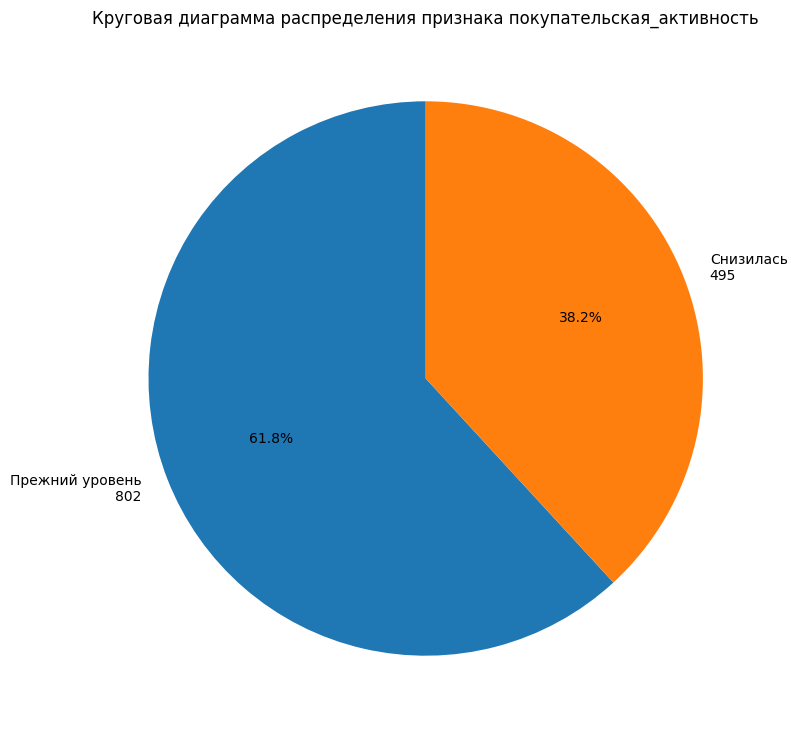

In [171]:
data_покупательская_активность_grouped_aggregated = data_покупательская_активность.groupby(by = 'покупательская_активность',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_покупательская_активность_grouped_aggregated['id'],\
                    data_покупательская_активность_grouped_aggregated.index, 'покупательская_активность')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'тип_сервиса'

Рассмотрим спектр значений признака.

In [172]:
data_тип_сервиса = dataset_market[['id', 'тип_сервиса']]
data_тип_сервиса['тип_сервиса'].value_counts()

тип_сервиса
стандарт    922
премиум     375
Name: count, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

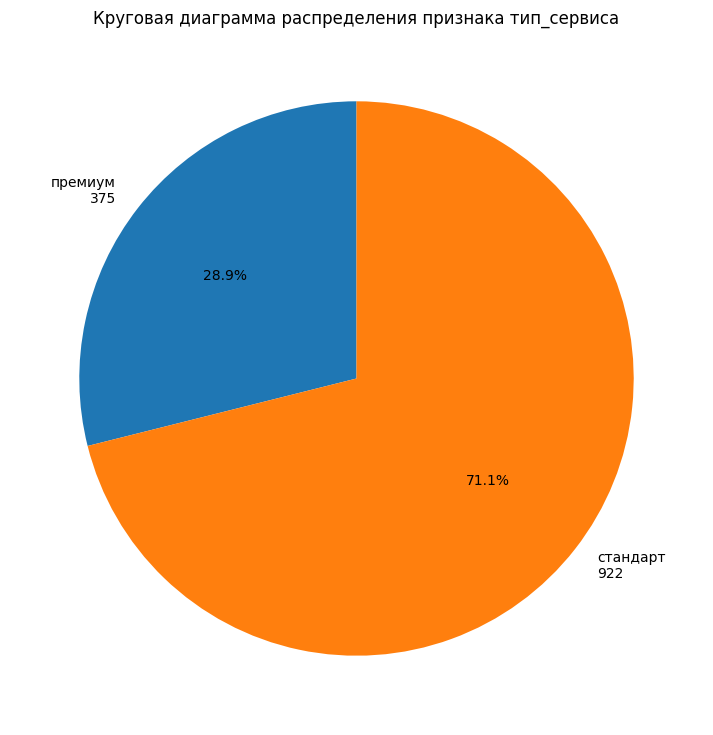

In [173]:
data_тип_сервиса_grouped_aggregated = data_тип_сервиса.groupby(by = 'тип_сервиса',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_тип_сервиса_grouped_aggregated['id'],\
                    data_тип_сервиса_grouped_aggregated.index, 'тип_сервиса')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'разрешить_сообщать'

Рассмотрим спектр значений признака.

In [174]:
data_разрешить_сообщать = dataset_market[['id', 'разрешить_сообщать']]
data_разрешить_сообщать['разрешить_сообщать'].value_counts()

разрешить_сообщать
да     959
нет    338
Name: count, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

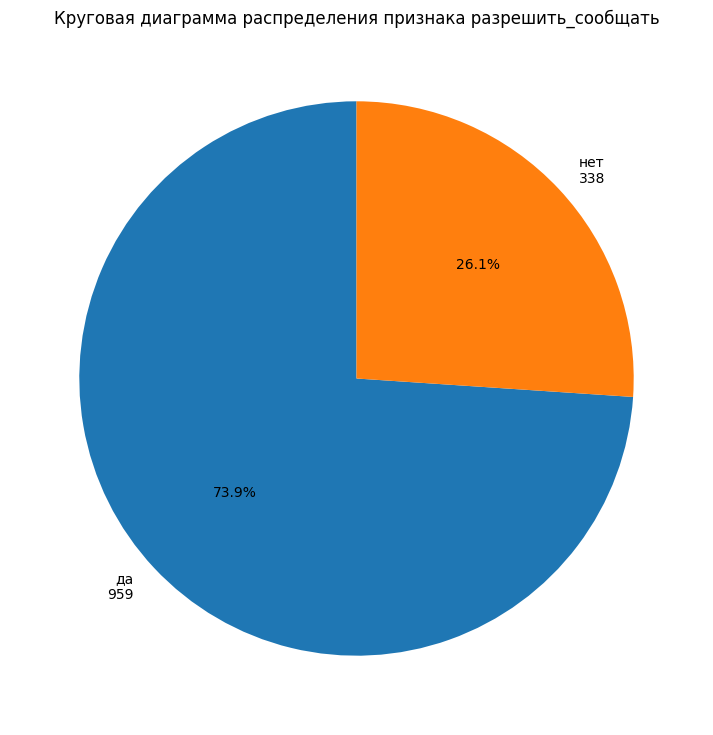

In [175]:
data_разрешить_сообщать_grouped_aggregated = data_разрешить_сообщать.groupby(by = 'разрешить_сообщать',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_разрешить_сообщать_grouped_aggregated['id'],\
                    data_разрешить_сообщать_grouped_aggregated.index, 'разрешить_сообщать')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'маркет_актив\_6\_мес'

Рассмотрим спектр значений признака.

In [176]:
data_маркет_актив_6_мес = dataset_market['маркет_актив_6_мес']
data_маркет_актив_6_мес.describe()

count   1,297.00
mean        4.25
std         1.02
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: маркет_актив_6_мес, dtype: float64

Признак - численный.

In [177]:
data_маркет_актив_6_мес.nunique()

41

В спектре значений 41 уникальная величина.

Представим распределение в виде диаграммы размаха и гистограммы.

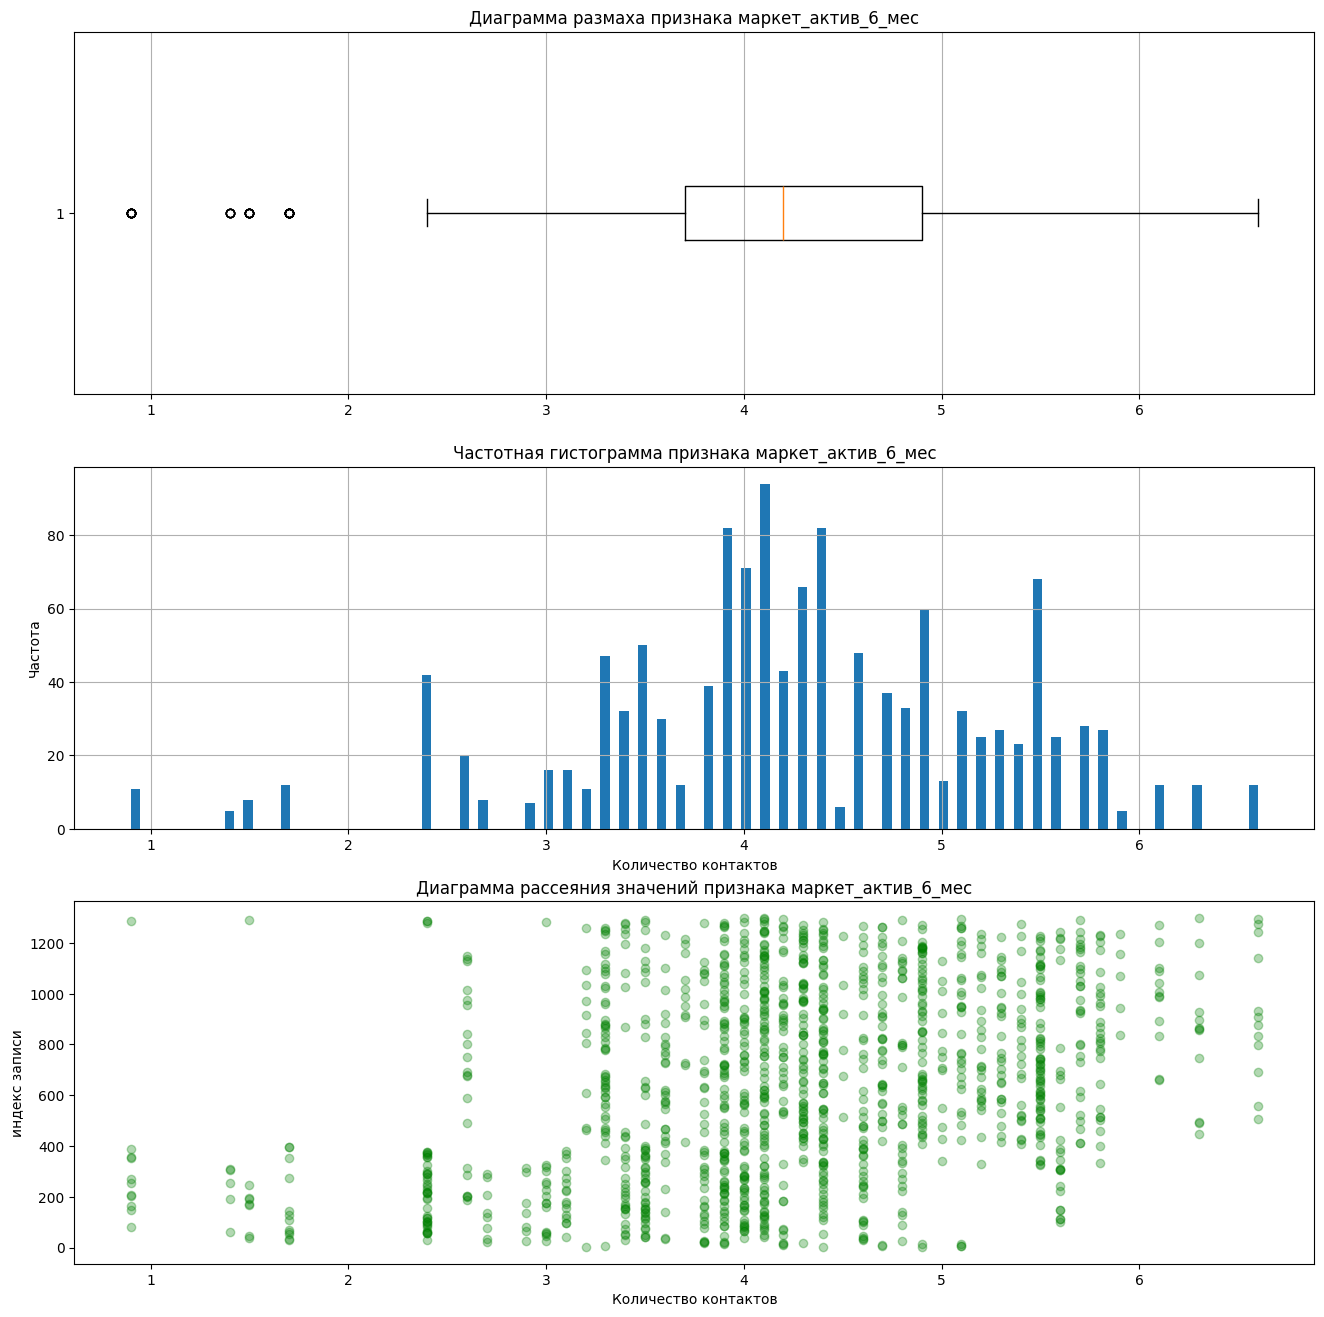

In [178]:
chart_attribute(data_маркет_актив_6_мес, 'маркет_актив_6_мес', 'Количество контактов', 120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [179]:
Anderson(data_маркет_актив_6_мес)

Статистика теста: 6.6409
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market, признак 'маркет_актив_тек_мес'

Рассмотрим спектр значений признака.

In [180]:
data_маркет_актив_тек_мес = dataset_market['маркет_актив_тек_мес']
data_маркет_актив_тек_мес.describe()

count   1,297.00
mean        4.01
std         0.70
min         3.00
25%         4.00
50%         4.00
75%         4.00
max         5.00
Name: маркет_актив_тек_мес, dtype: float64

Признак - численный.

In [181]:
data_маркет_актив_тек_мес.nunique()

3

В спектре значений всего 3 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.

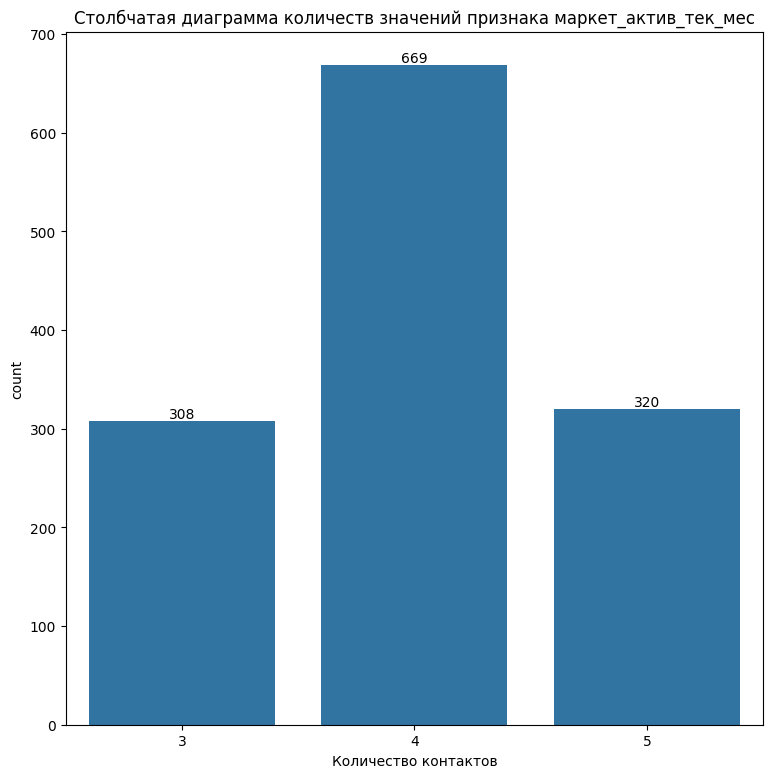

In [182]:
chart_attribute_discrete(data_маркет_актив_тек_мес, 'маркет_актив_тек_мес', 'Количество контактов')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'длительность'

Рассмотрим спектр значений признака.

In [183]:
data_длительность = dataset_market['длительность']
data_длительность.describe()

count   1,297.00
mean      602.99
std       249.10
min       121.00
25%       410.00
50%       607.00
75%       806.00
max     1,079.00
Name: длительность, dtype: float64

Признак - численный.

In [184]:
data_длительность.nunique()

657

В спектре значений 657 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

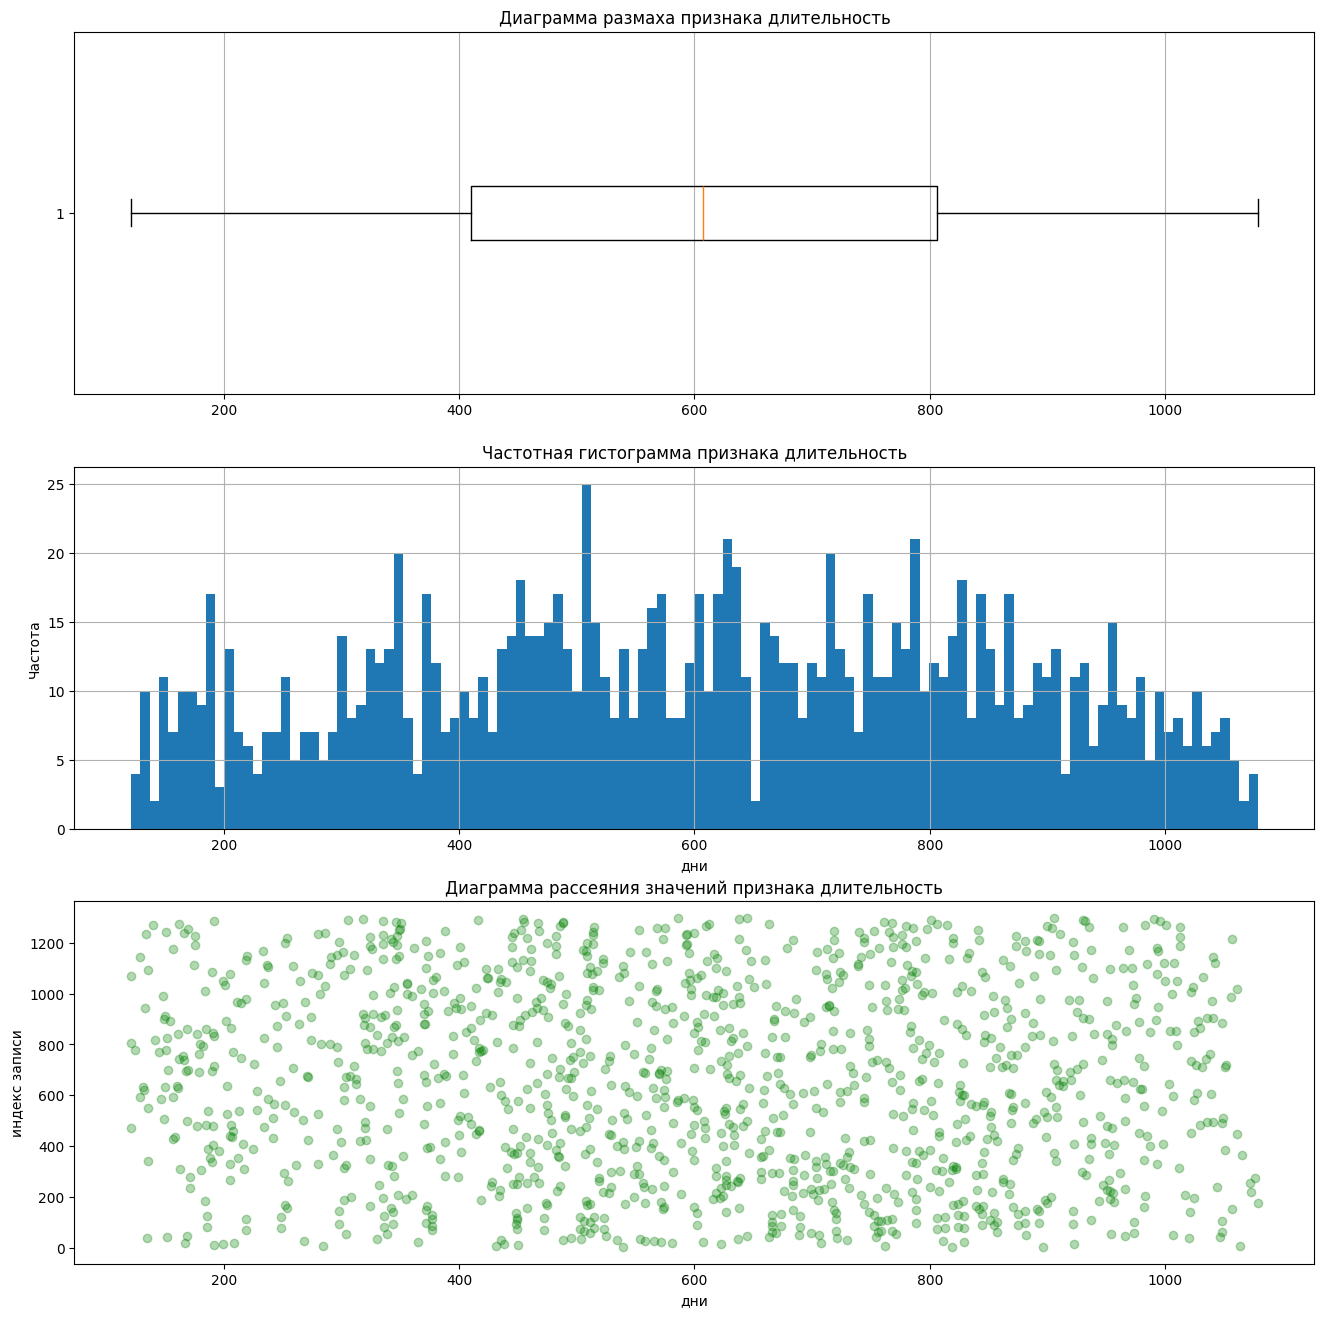

In [185]:
chart_attribute(data_длительность, 'длительность', 'дни',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [186]:
Anderson(data_длительность)

Статистика теста: 7.3728
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market, признак 'акционные_покупки'

Рассмотрим спектр значений признака.

In [187]:
data_акционные_покупки = dataset_market['акционные_покупки']
data_акционные_покупки.describe()

count   1,297.00
mean        0.32
std         0.25
min         0.11
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: акционные_покупки, dtype: float64

Признак - численный.

In [188]:
data_акционные_покупки.nunique()

41

В спектре значений 41 уникальная величина.

Представим распределение в виде диаграммы размаха и гистограммы.

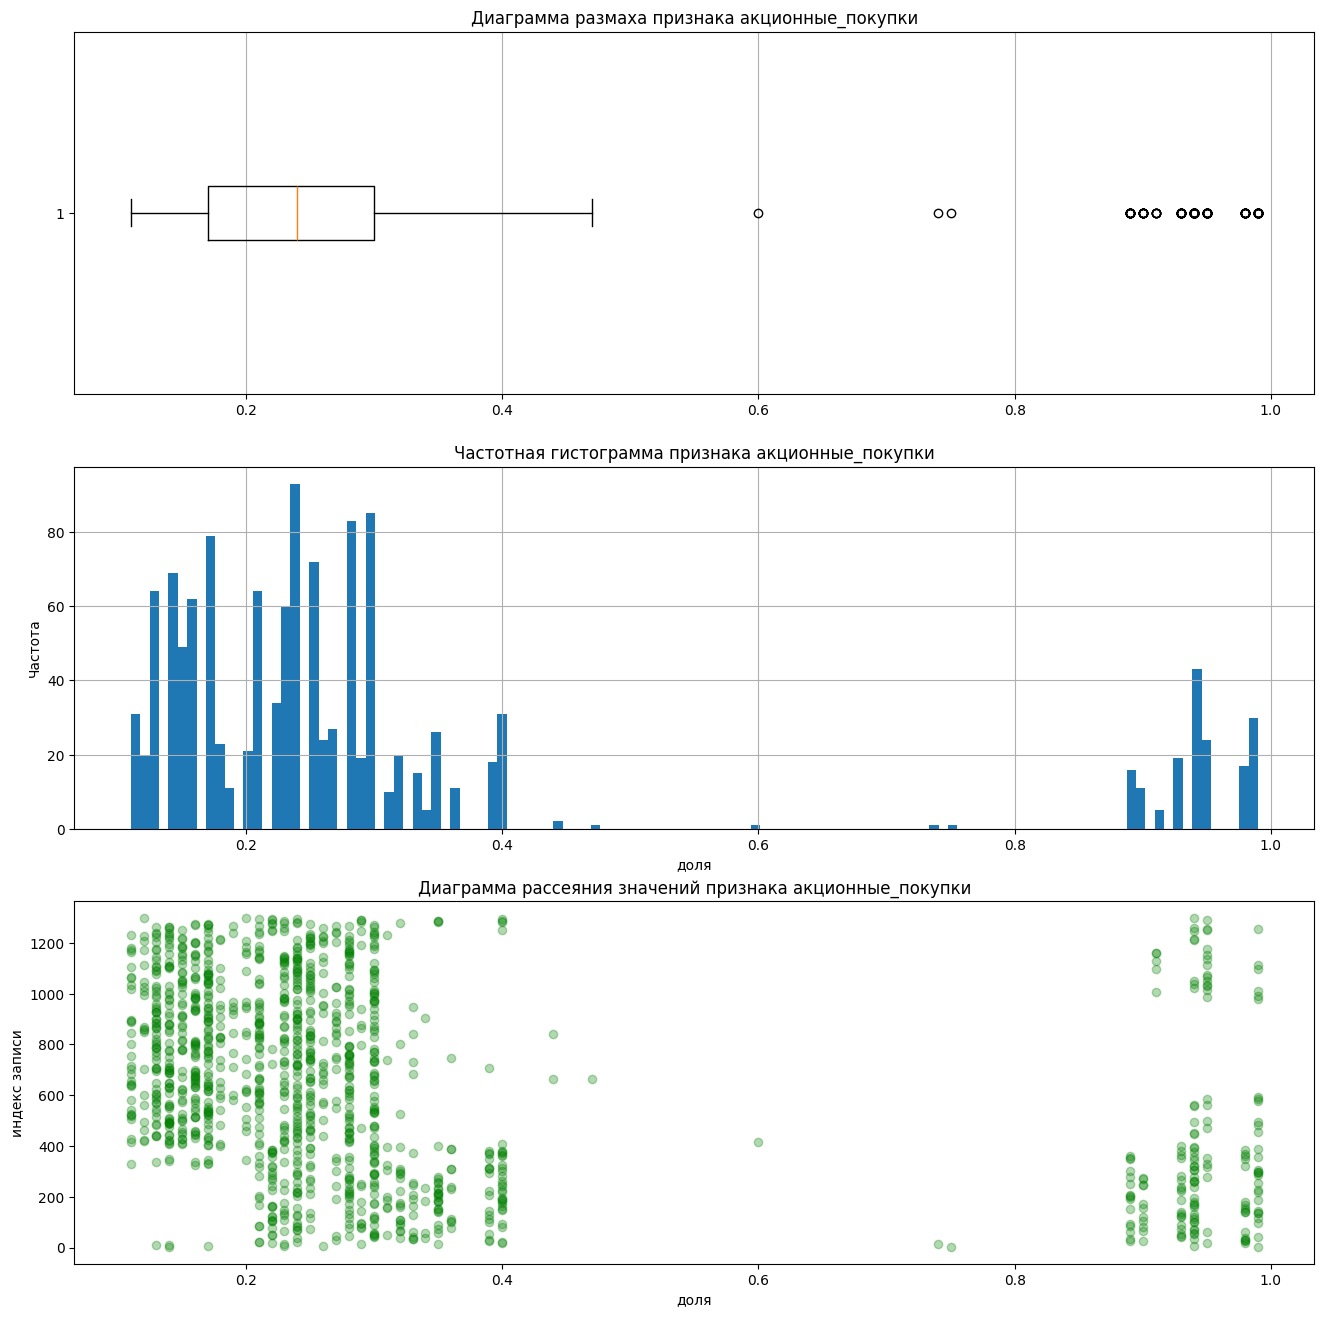

In [189]:
chart_attribute(data_акционные_покупки, 'акционные_покупки', 'доля',  120)

Очевидно, что без статистического теста, можно утверждать о не нормальности распределения значений признака.

### Набор данных dataset_market, признак 'популярная_категория'

In [190]:
data_популярная_категория = dataset_market[['id', 'популярная_категория']]
data_популярная_категория['популярная_категория'].value_counts()

популярная_категория
Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесуары                   223
Техника для красоты и здоровья          183
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

Признак - категориальный. Спектр значений - дискретный.

Представим распределение в виде круговой диаграммы.

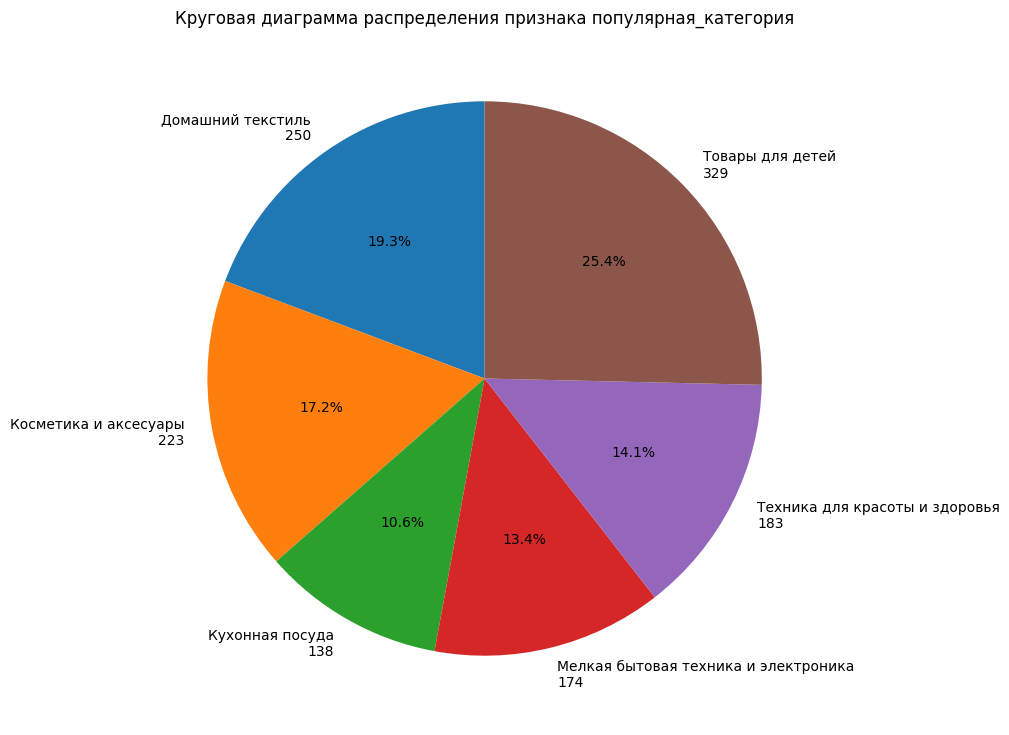

In [191]:
data_популярная_категория_grouped_aggregated = data_популярная_категория.groupby(by = 'популярная_категория',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_популярная_категория_grouped_aggregated['id'],\
                    data_популярная_категория_grouped_aggregated.index, 'популярная_категория')

Распределение значений признака по классам, можно считать сбалансированым.

### Набор данных dataset_market, признак 'средний_просмотр_категорий_за_визит'

Рассмотрим спектр значений признака.

In [192]:
data_средний_просмотр_категорий_за_визит = dataset_market['средний_просмотр_категорий_за_визит']
data_средний_просмотр_категорий_за_визит.describe()

count   1,297.00
mean        3.27
std         1.35
min         1.00
25%         2.00
50%         3.00
75%         4.00
max         6.00
Name: средний_просмотр_категорий_за_визит, dtype: float64

Признак - численный.

In [193]:
data_средний_просмотр_категорий_за_визит.nunique()

6

В спектре значений всего 6 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.


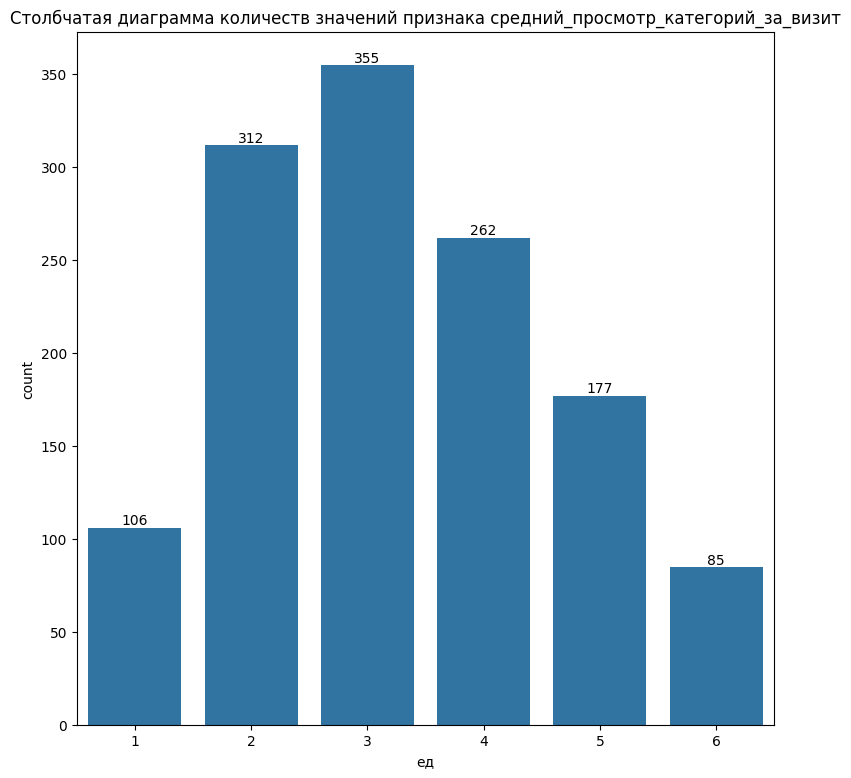

In [194]:
chart_attribute_discrete(data_средний_просмотр_категорий_за_визит, 'средний_просмотр_категорий_за_визит', 'ед')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'неоплаченные_продукты_штук_квартал'

Рассмотрим спектр значений признака.

In [195]:
data_неоплаченные_продукты_штук_квартал = dataset_market['неоплаченные_продукты_штук_квартал']
data_неоплаченные_продукты_штук_квартал.describe()

count   1,297.00
mean        2.84
std         1.97
min         0.00
25%         1.00
50%         3.00
75%         4.00
max        10.00
Name: неоплаченные_продукты_штук_квартал, dtype: float64

Признак - численный.

In [196]:
data_неоплаченные_продукты_штук_квартал.nunique()

11

В спектре значений всего 11 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.

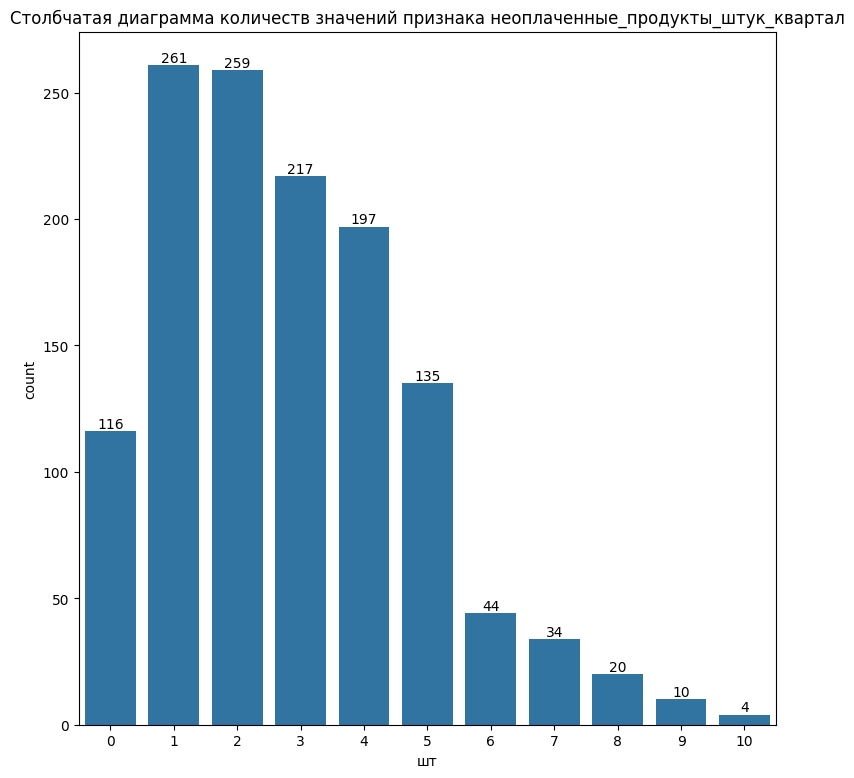

In [197]:
chart_attribute_discrete(data_неоплаченные_продукты_штук_квартал, 'неоплаченные_продукты_штук_квартал', 'шт')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'ошибка_сервиса'

Рассмотрим спектр значений признака.

In [198]:
data_ошибка_сервиса = dataset_market['ошибка_сервиса']
data_ошибка_сервиса.describe()

count   1,297.00
mean        4.18
std         1.95
min         0.00
25%         3.00
50%         4.00
75%         6.00
max         9.00
Name: ошибка_сервиса, dtype: float64

Признак - численный.

In [199]:
data_ошибка_сервиса.nunique()

10

В спектре значений всего 10 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.


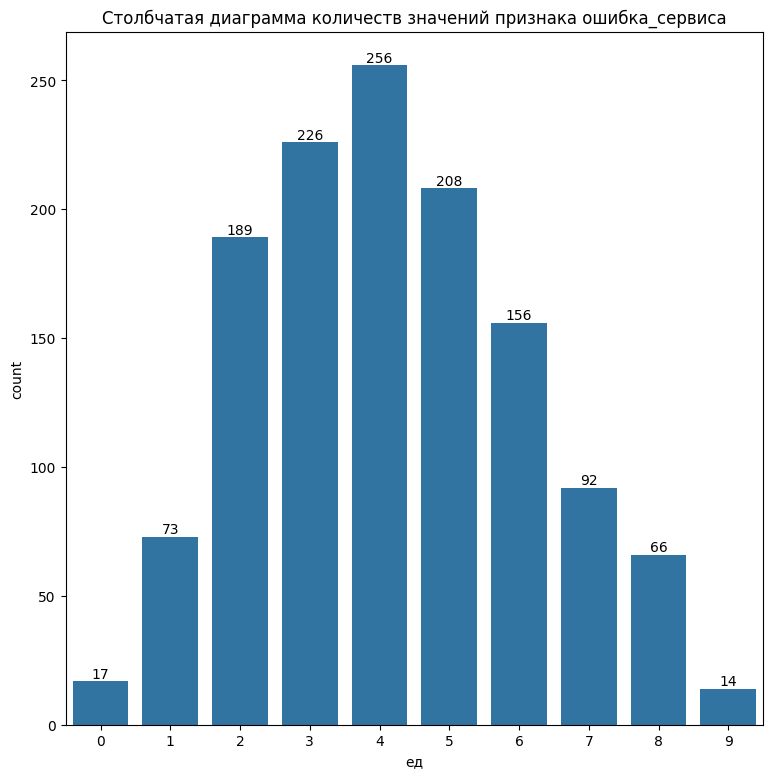

In [200]:
chart_attribute_discrete(data_ошибка_сервиса, 'ошибка_сервиса', 'ед')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'страниц_за_визит'

Рассмотрим спектр значений признака.

In [201]:
data_страниц_за_визит = dataset_market['страниц_за_визит']
data_страниц_за_визит.describe()

count   1,297.00
mean        8.19
std         3.98
min         1.00
25%         5.00
50%         8.00
75%        11.00
max        20.00
Name: страниц_за_визит, dtype: float64

Признак - численный.

In [202]:
data_страниц_за_визит.nunique()

20

В спектре значений 20 уникальная величина.

Представим распределение в виде диаграммы размаха и гистограммы.

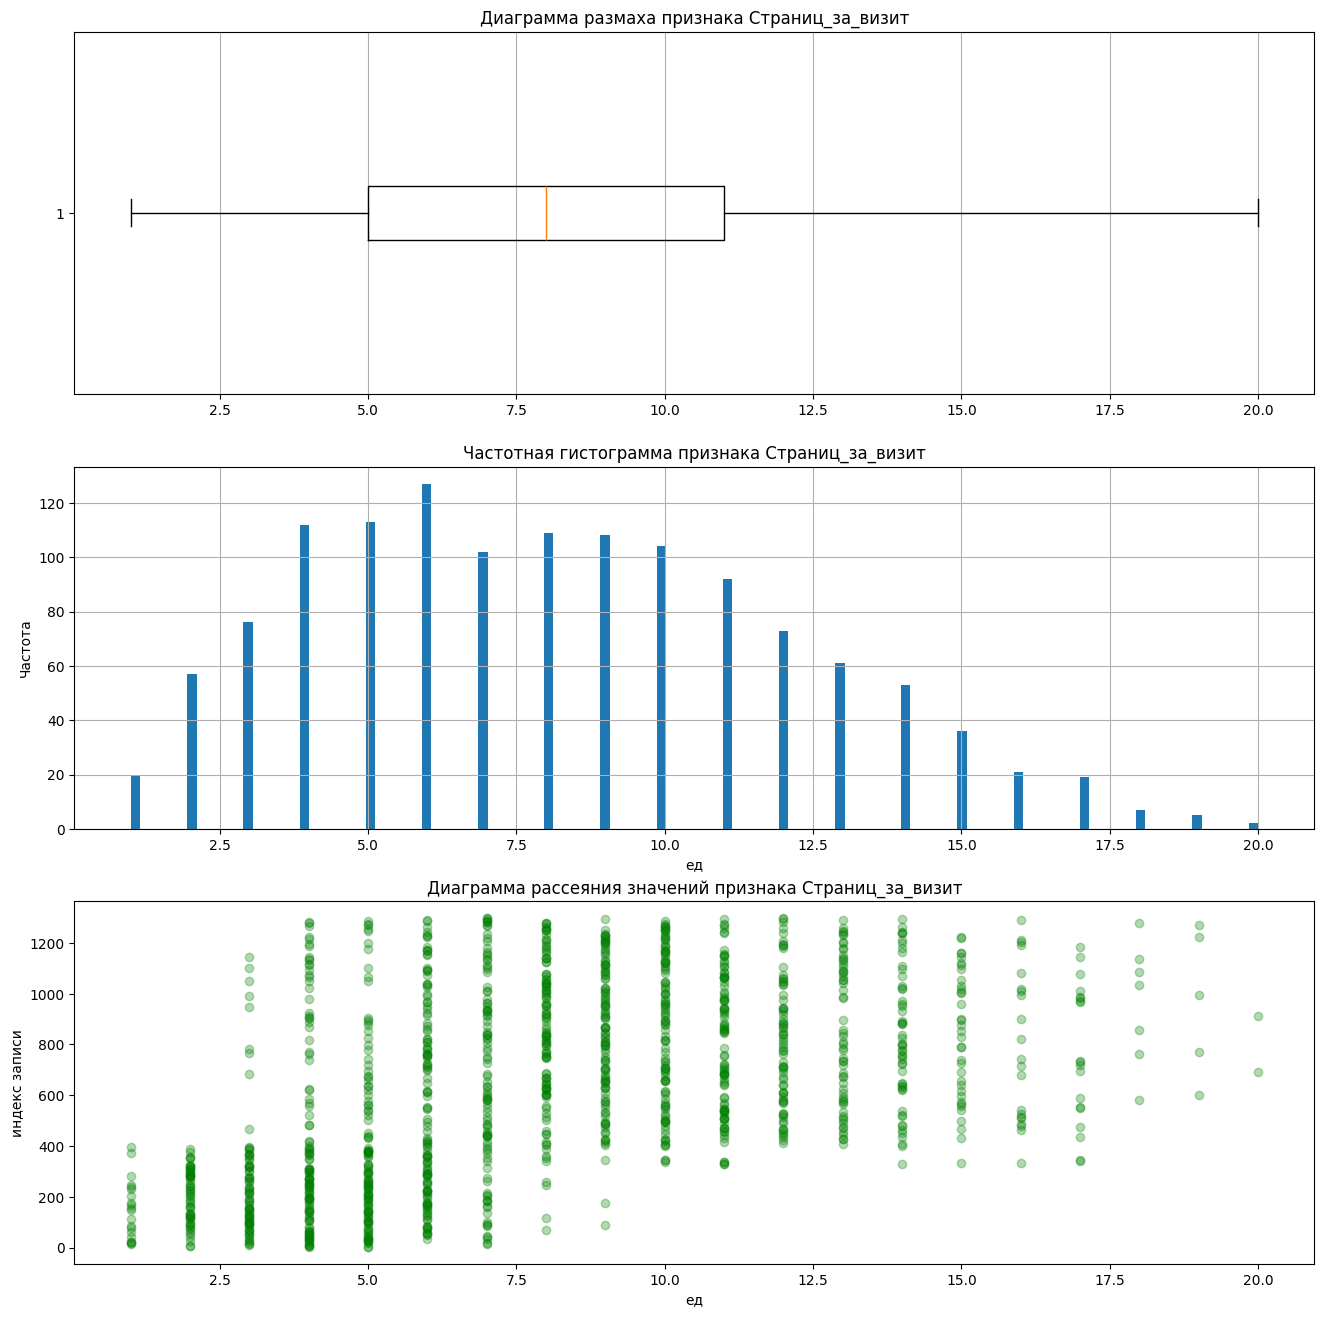

In [203]:
chart_attribute(data_страниц_за_визит, 'Страниц_за_визит', 'ед',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [204]:
Anderson(data_страниц_за_визит)

Статистика теста: 9.5429
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market_money, признак 'период'

Рассмотрим спектр значений признака.

In [205]:
data_money_период = dataset_market_money[['id', 'период']]
data_money_период['период'].value_counts()

период
препредыдущий_месяц    1297
текущий_месяц          1297
предыдущий_месяц       1297
Name: count, dtype: int64

Признак - категориальный. Спектр значений - дискретный.

Представим распределение в виде круговой диаграммы.

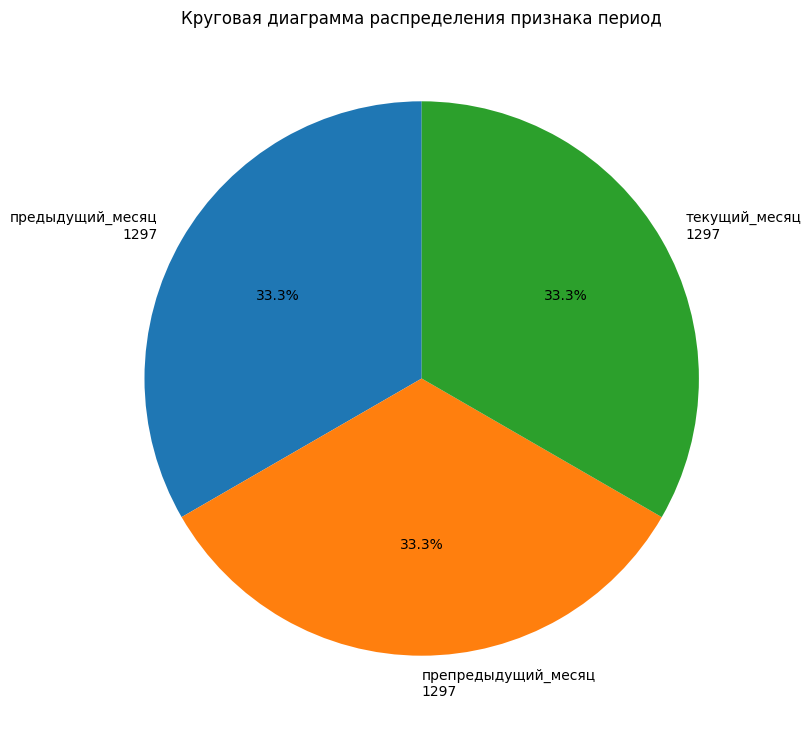

In [206]:
data_money_период_grouped_aggregated = data_money_период.groupby(by = 'период',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_money_период_grouped_aggregated['id'],\
                    data_money_период_grouped_aggregated.index, 'период')

Распределение значений признака сбалансированно по классам.

### Набор данных dataset_market_money, признак 'выручка'

Рассмотрим спектр значений признака.

In [207]:
data_money_выручка = dataset_market_money['выручка']
data_money_выручка.describe()

count     3,891.00
mean      5,033.72
std       1,768.47
min       2,758.70
25%       4,592.00
50%       4,959.00
75%       5,363.20
max     106,862.20
Name: выручка, dtype: float64

Признак - численный.

In [208]:
data_money_выручка.nunique()

2773

В спектре значений 2773 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

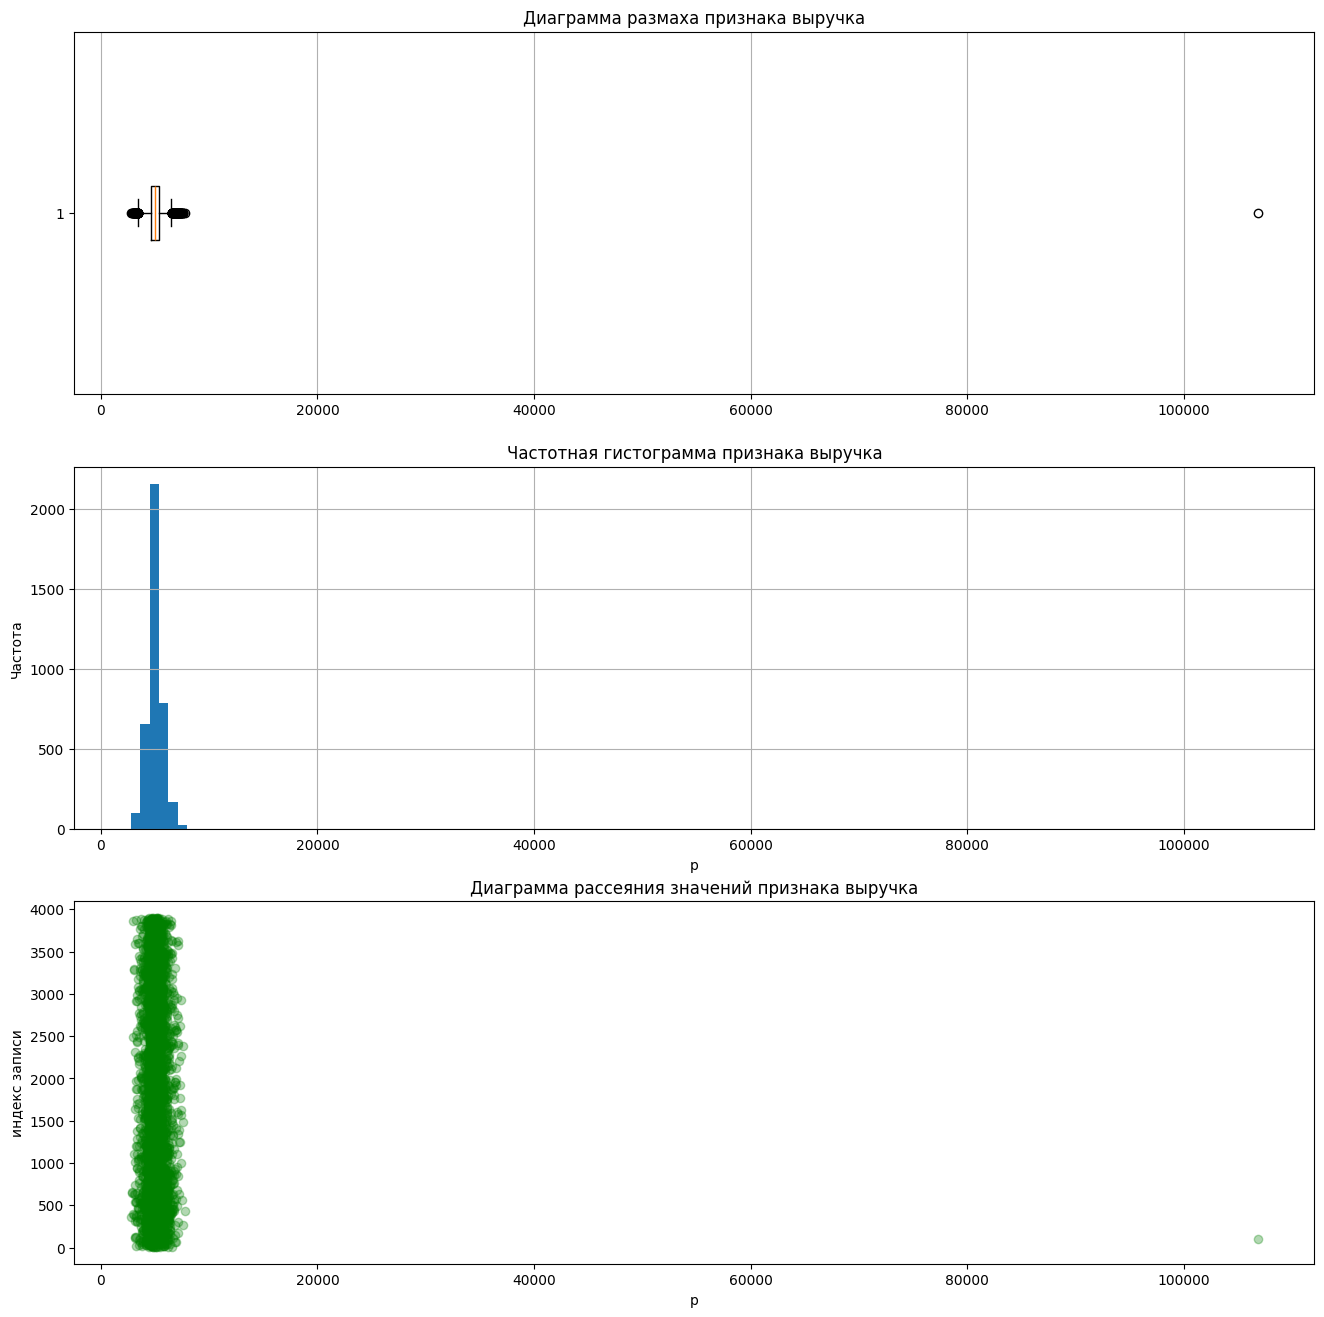

In [209]:
chart_attribute(data_money_выручка, 'выручка', 'р',  120)

Аномально большое значение. Следует удалить.

Выведем запись набора данных dataset_market_money с аномально высоким значением выручки.

In [210]:
display(dataset_market_money[dataset_market_money['выручка'] > 100000])

id         период    выручка
98  215380  текущий_месяц 106,862.20

In [211]:
dataset_market_money = dataset_market_money[dataset_market_money['id'] != 215380]

Повторим построение и визуализацию поднабора данных без аномальной выручки.

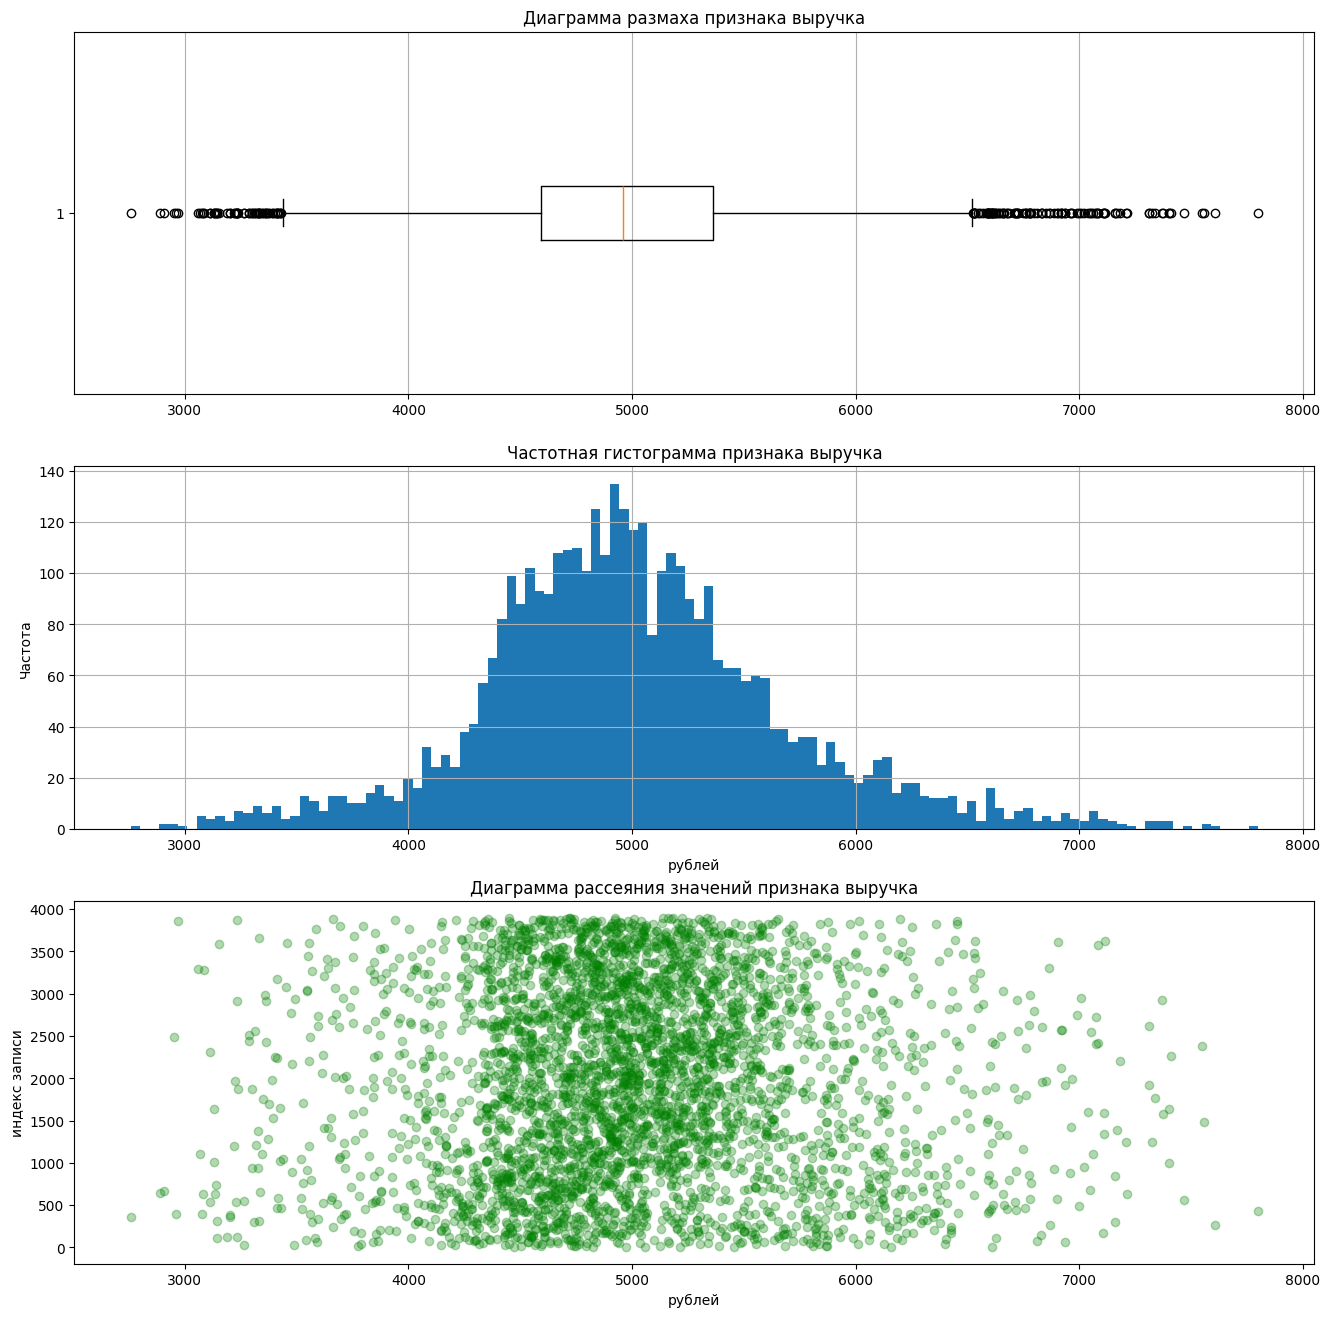

In [212]:
data_money_выручка = dataset_market_money['выручка']
chart_attribute(data_money_выручка, 'выручка', 'рублей',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [213]:
Anderson(data_money_выручка)

Статистика теста: 21.8402
Критическое значение для 5% уровня значимости: 0.7860
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market_money, трансформация признака 'выручка'

Развернём набор данных dataset_market_money, так что бы выручки по периодам стали отдельными признаками.

In [214]:
dataset_market_money = dataset_market_money.pivot(index='id', columns='период', values='выручка')
dataset_market_money = dataset_market_money.add_prefix('выручка_')

In [215]:
dataset_market_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   выручка_предыдущий_месяц     1296 non-null   float64
 1   выручка_препредыдущий_месяц  1296 non-null   float64
 2   выручка_текущий_месяц        1296 non-null   float64
dtypes: float64(3)
memory usage: 40.5 KB


In [216]:
dataset_market_money.sample(5)

период  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215708                  6,085.50                     4,974.00   
216323                  5,584.50                     4,422.00   
216620                  5,486.00                     5,396.00   
215514                  5,994.00                     4,839.00   
215950                  5,124.50                     4,415.00   

период  выручка_текущий_месяц  
id                             
215708               6,216.80  
216323               6,722.00  
216620               5,538.00  
215514               6,125.30  
215950               5,869.40

**Выручка за препредыдущий месяц**

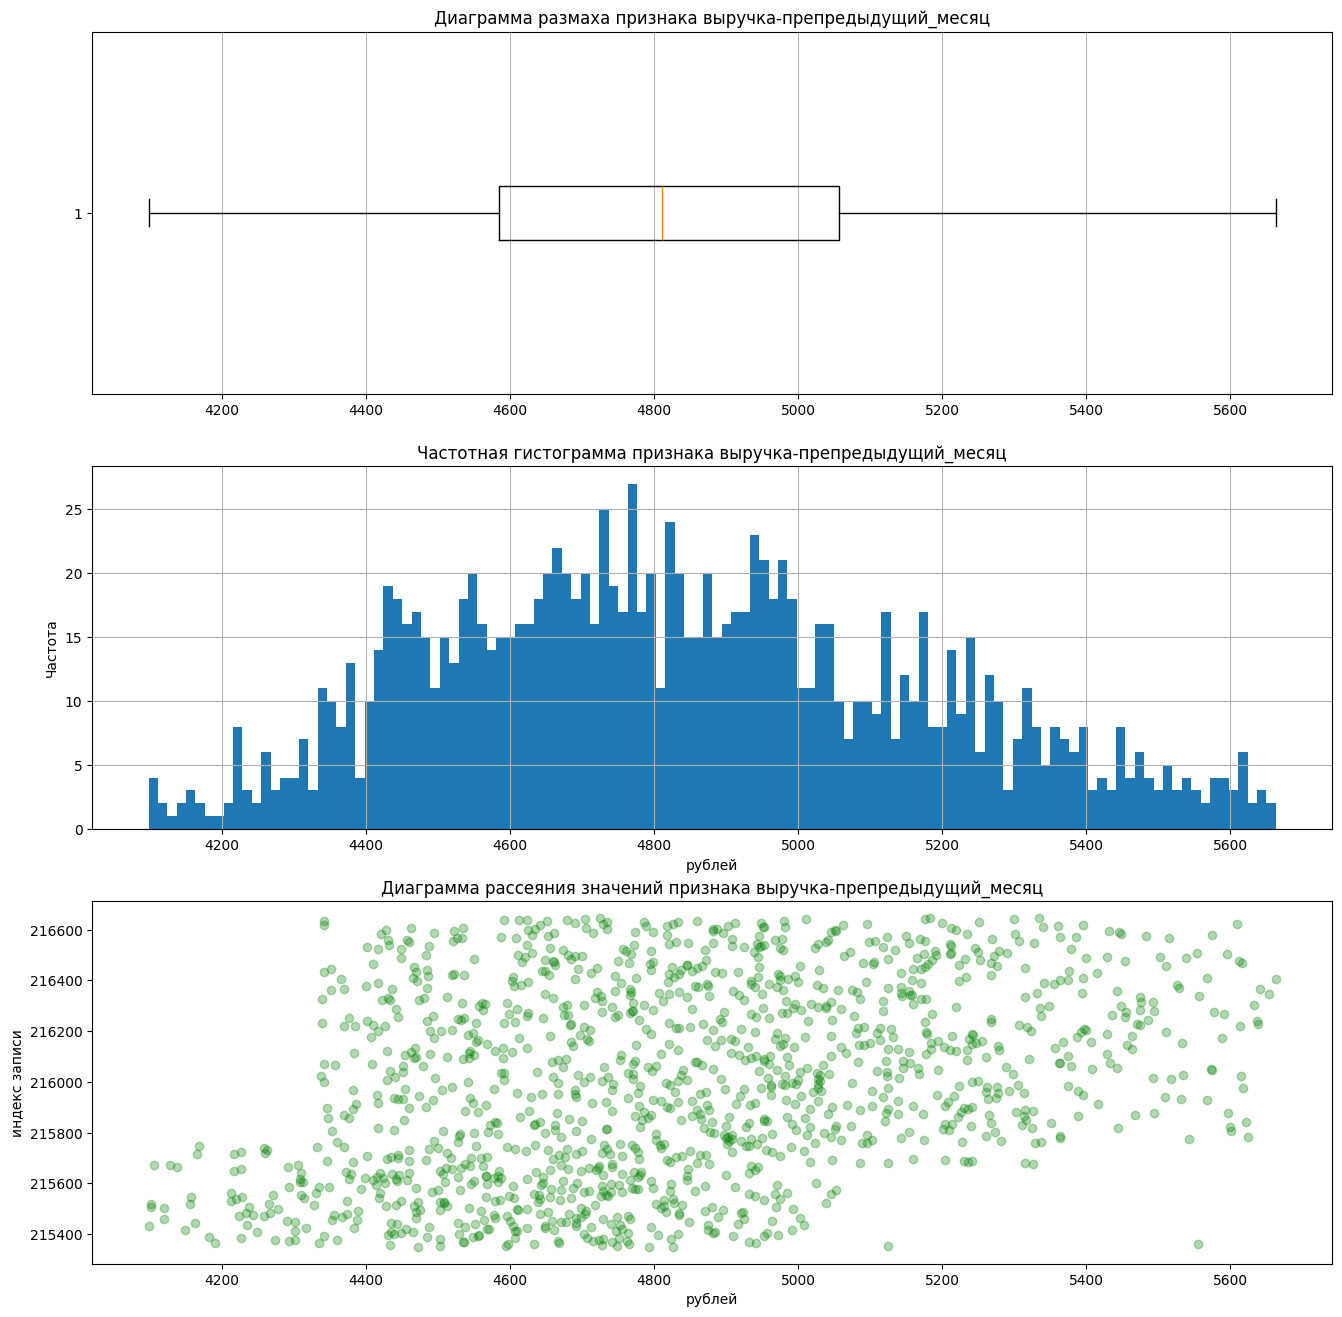

In [217]:
chart_attribute(dataset_market_money['выручка_препредыдущий_месяц'], 'выручка-препредыдущий_месяц', 'рублей',  120)

In [218]:
Anderson(dataset_market_money['выручка_препредыдущий_месяц'])

Статистика теста: 4.1512
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


**Выручка за предыдущий месяц**

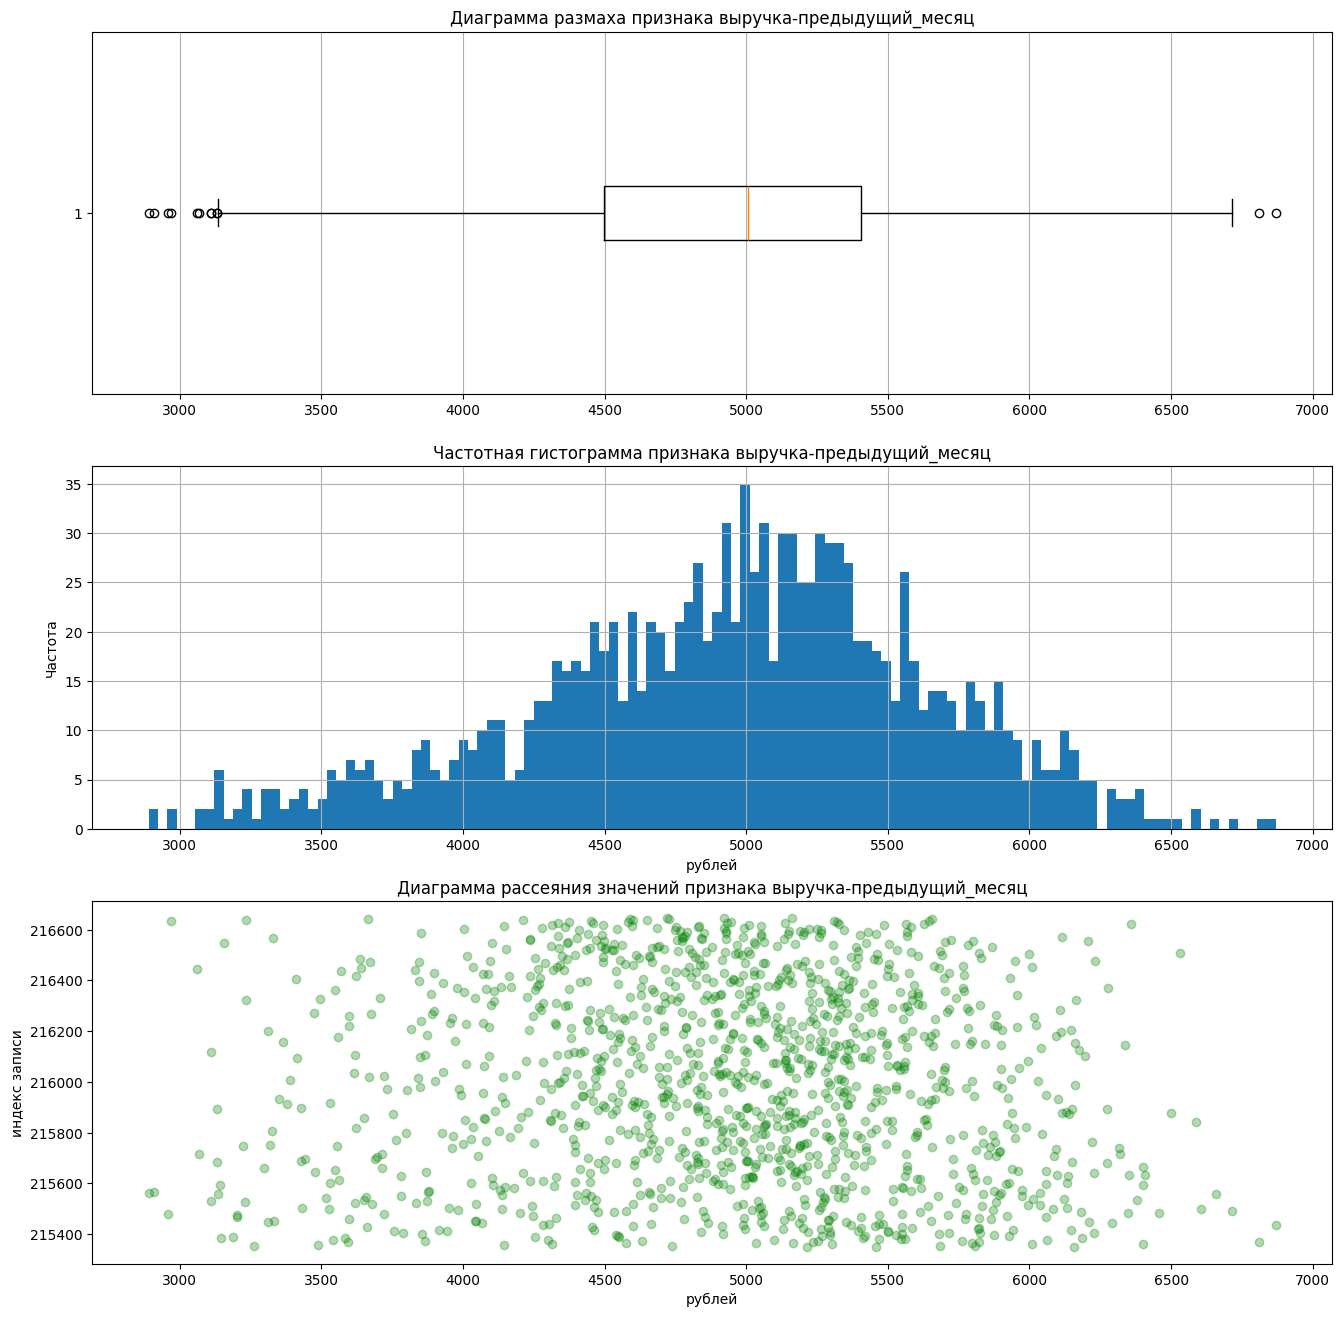

In [219]:
chart_attribute(dataset_market_money['выручка_предыдущий_месяц'], 'выручка-предыдущий_месяц', 'рублей',  120)

In [220]:
Anderson(dataset_market_money['выручка_предыдущий_месяц'])

Статистика теста: 3.4391
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


**Выручка за текущий месяц**

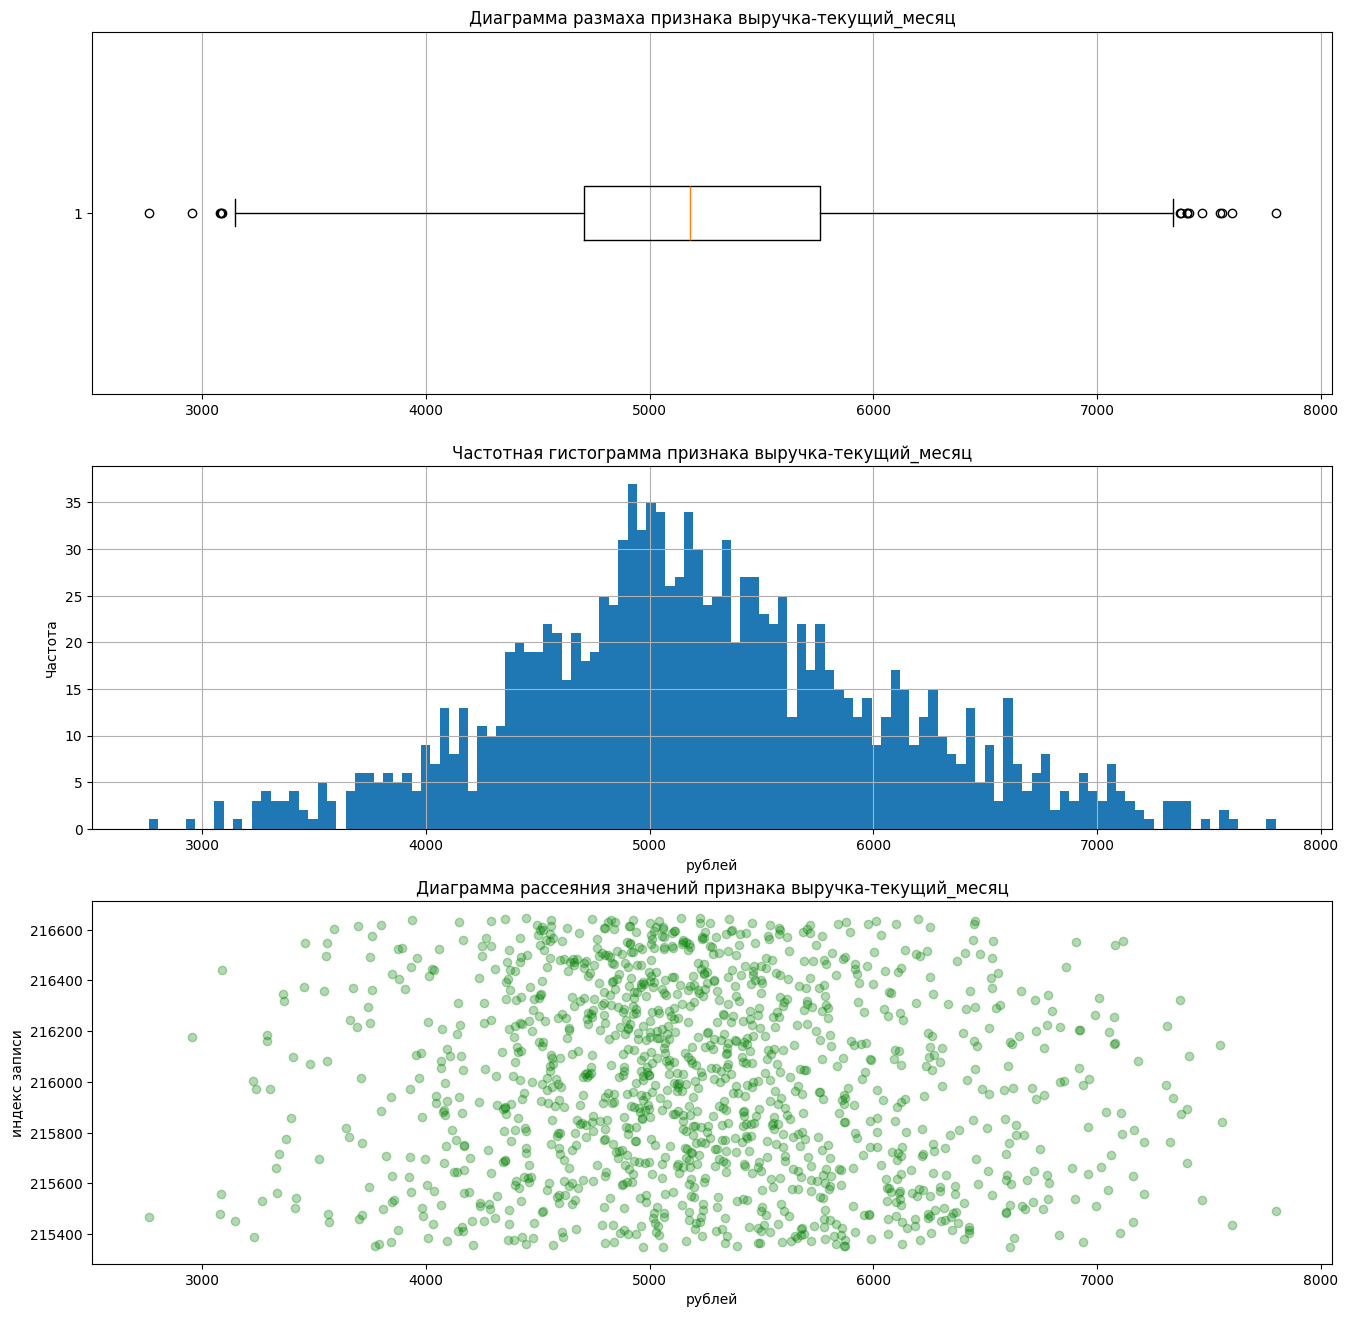

In [221]:
chart_attribute(dataset_market_money['выручка_текущий_месяц'], 'выручка-текущий_месяц', 'рублей',  120)

In [222]:
Anderson(dataset_market_money['выручка_текущий_месяц'])

Статистика теста: 2.5729
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


### Набор данных dataset_market_time, признак 'период'

Рассмотрим спектр значений признака.

In [223]:
data_time_период = dataset_market_time[['id', 'период']]
data_time_период['период'].value_counts()

период
текущий_месяц       1297
предыдущий_месяц    1297
Name: count, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

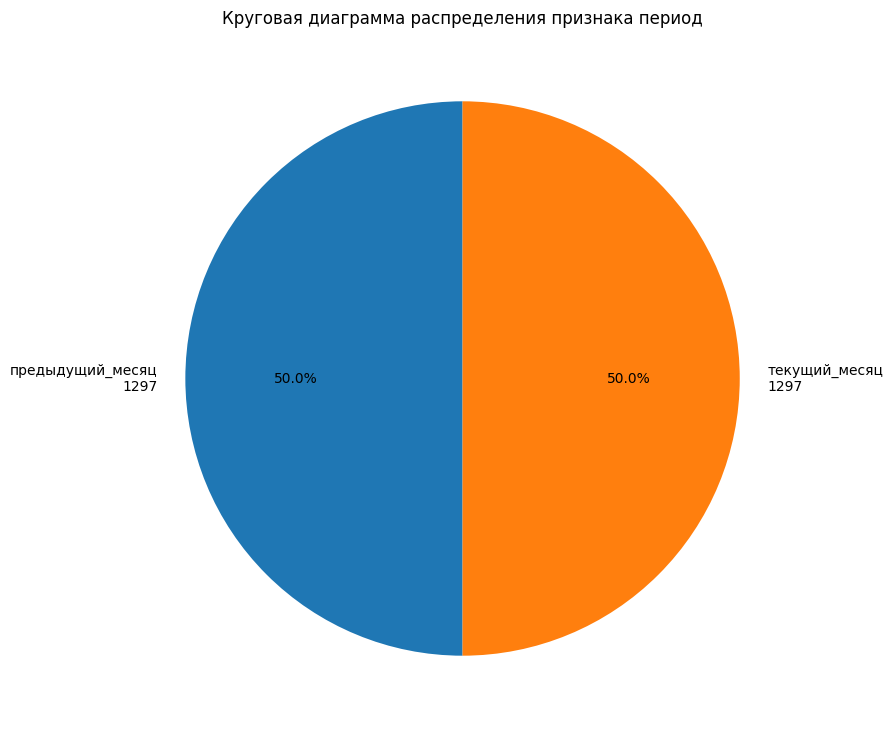

In [224]:
data_time_период_grouped_aggregated = data_time_период.groupby(by = 'период',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_time_период_grouped_aggregated['id'],\
                    data_time_период_grouped_aggregated.index, 'период')

Распределение значений признака сбалансированно по классам.

### Набор данных dataset_market_time, признак 'минут'

Рассмотрим спектр значений признака.

In [225]:
data_time_минут = dataset_market_time['минут']
data_time_минут.describe()

count   2,594.00
mean       13.34
std         4.08
min         4.00
25%        10.00
50%        13.00
75%        16.00
max        23.00
Name: минут, dtype: float64

Признак - численный.

In [226]:
data_time_минут.nunique()

20

В спектре значений 20 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

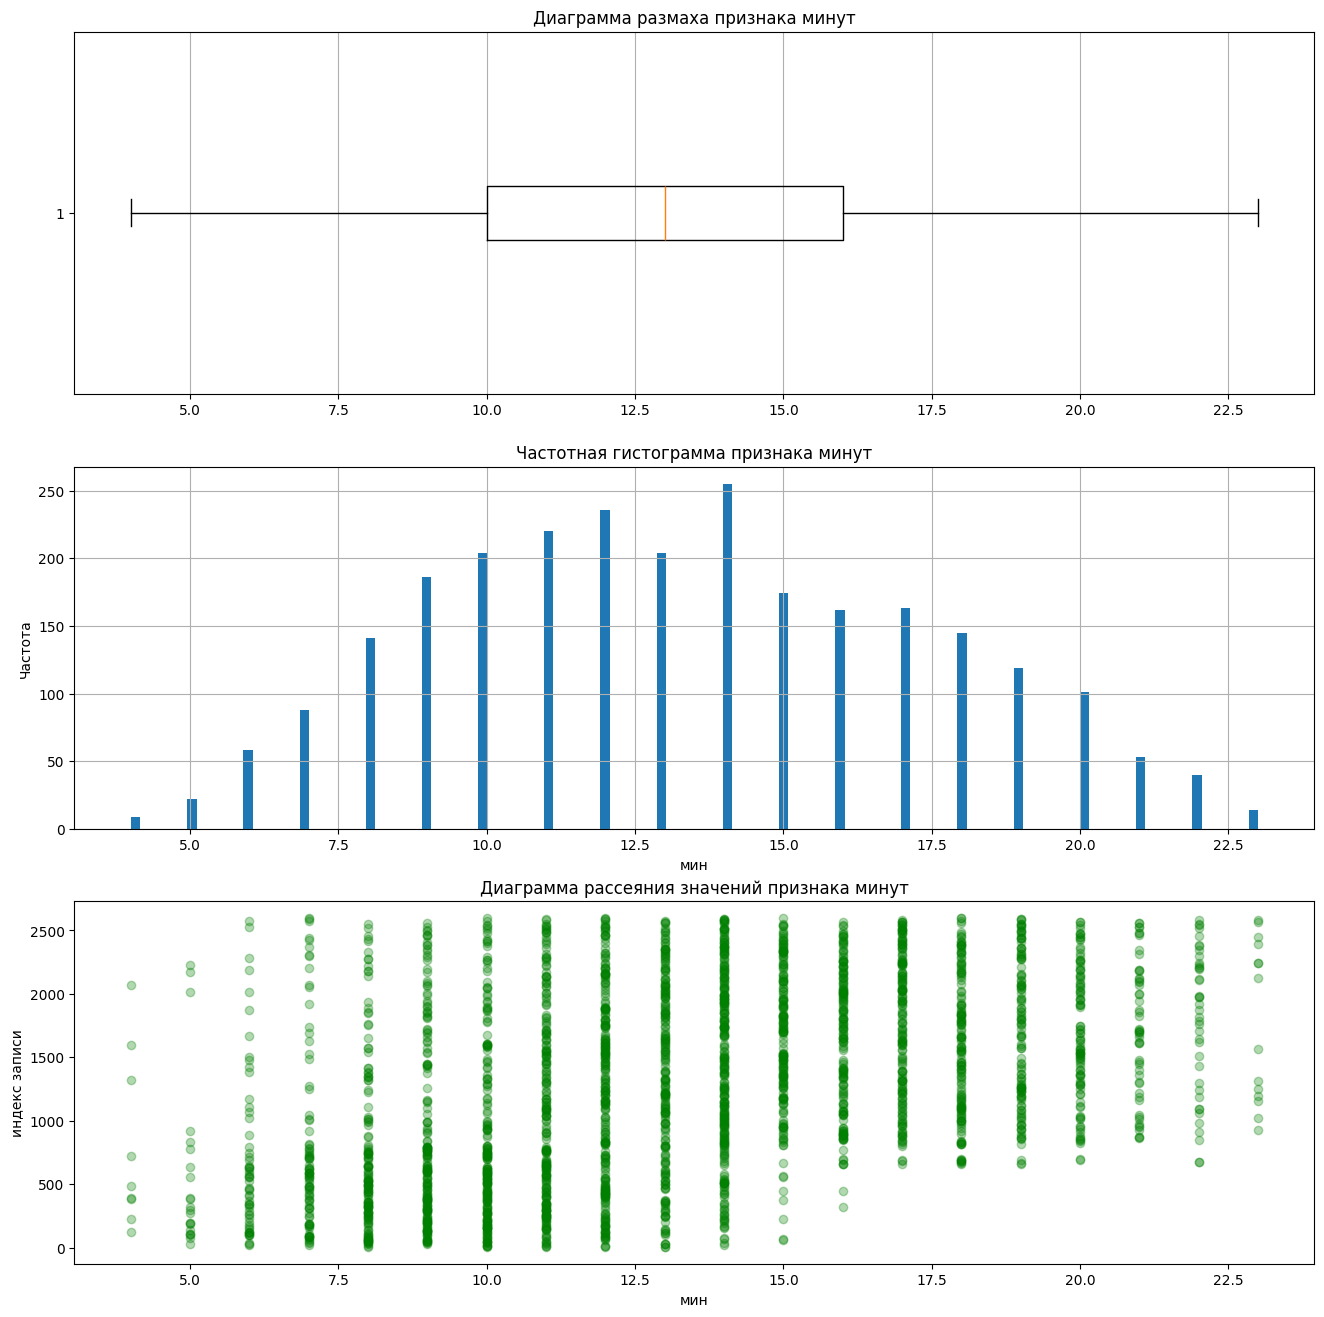

In [227]:
chart_attribute(data_time_минут, 'минут', 'мин',  120)

In [228]:
Anderson(data_time_минут)

Статистика теста: 13.7920
Критическое значение для 5% уровня значимости: 0.7860
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


### Набор данных dataset_market_time, трансформация признака 'минут'

In [229]:
dataset_market_time = dataset_market_time.pivot(index='id', columns='период', values='минут')
dataset_market_time = dataset_market_time.add_prefix('минут_')

In [230]:
dataset_market_time.sample(5)

период  минут_предыдущий_месяц  минут_текущий_месяц
id                                                 
215610                      13                    8
215688                      18                   11
215468                       9                   11
216641                      14                   12
215690                      13                   14

**Присутствие покупателей на сайте за предыдущий месяц**

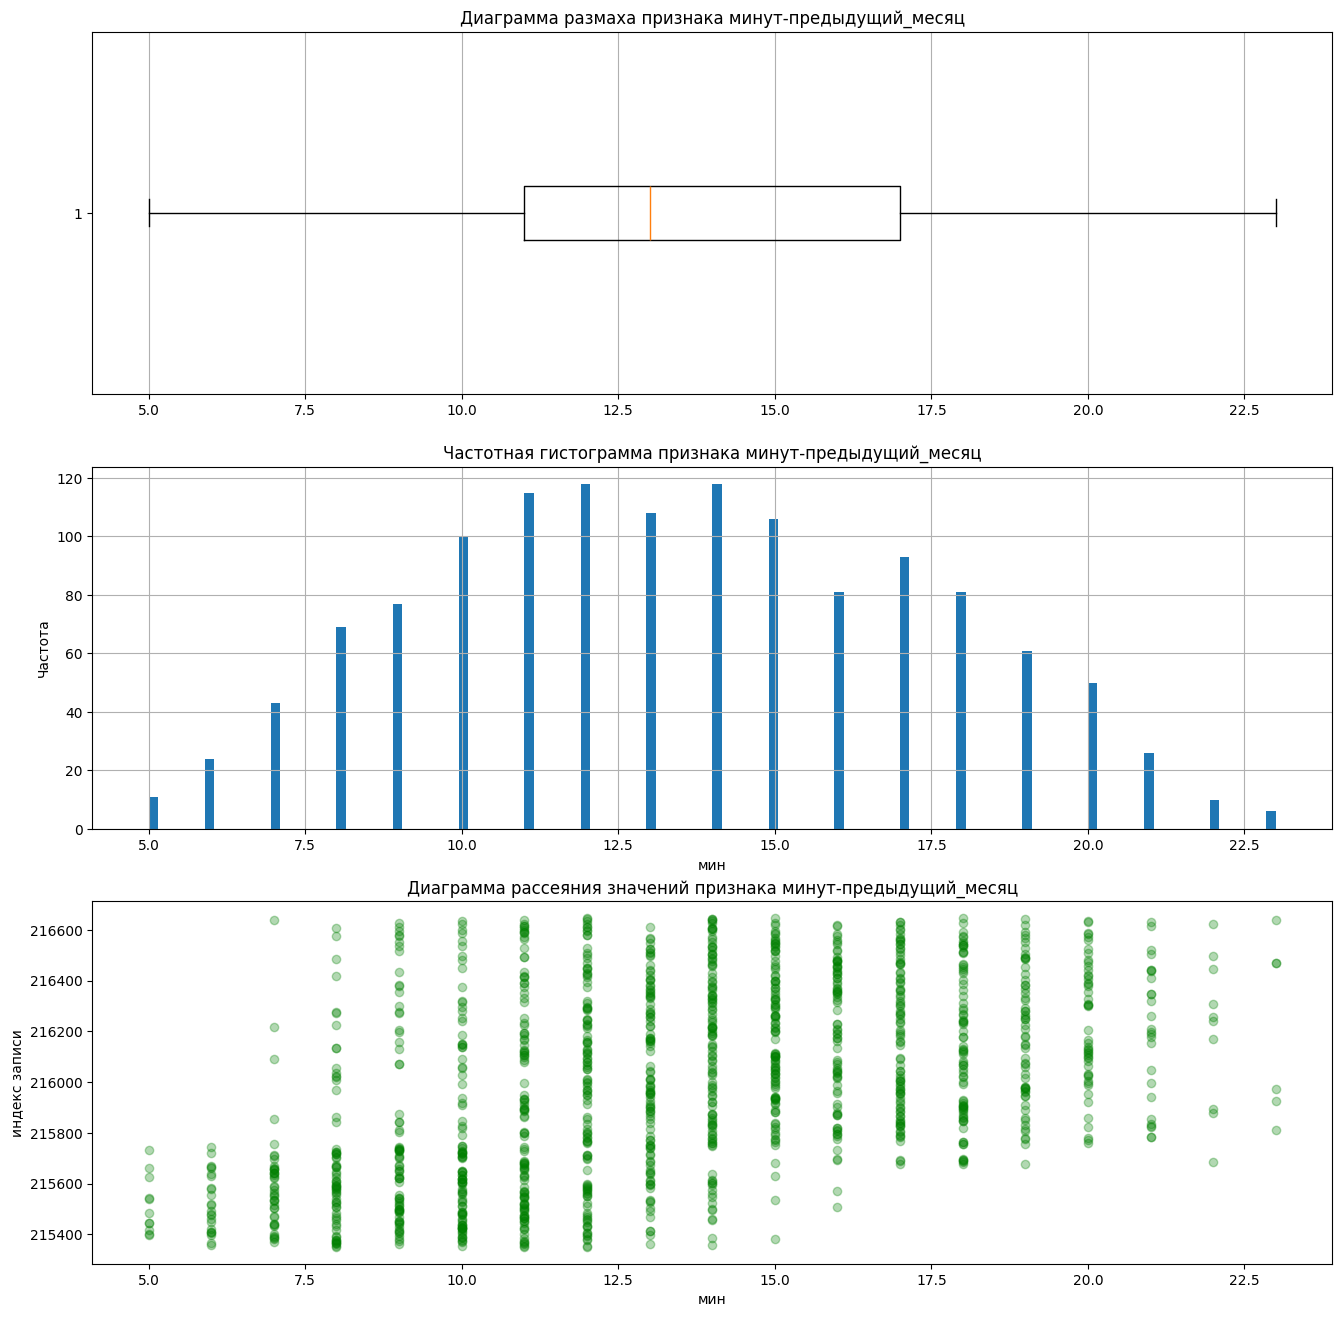

In [231]:
chart_attribute(dataset_market_time['минут_предыдущий_месяц'], 'минут-предыдущий_месяц', 'мин',  120)

In [232]:
Anderson(dataset_market_time['минут_предыдущий_месяц'])

Статистика теста: 6.6536
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


**Присутствие покупателей на сайте за текущий месяц**

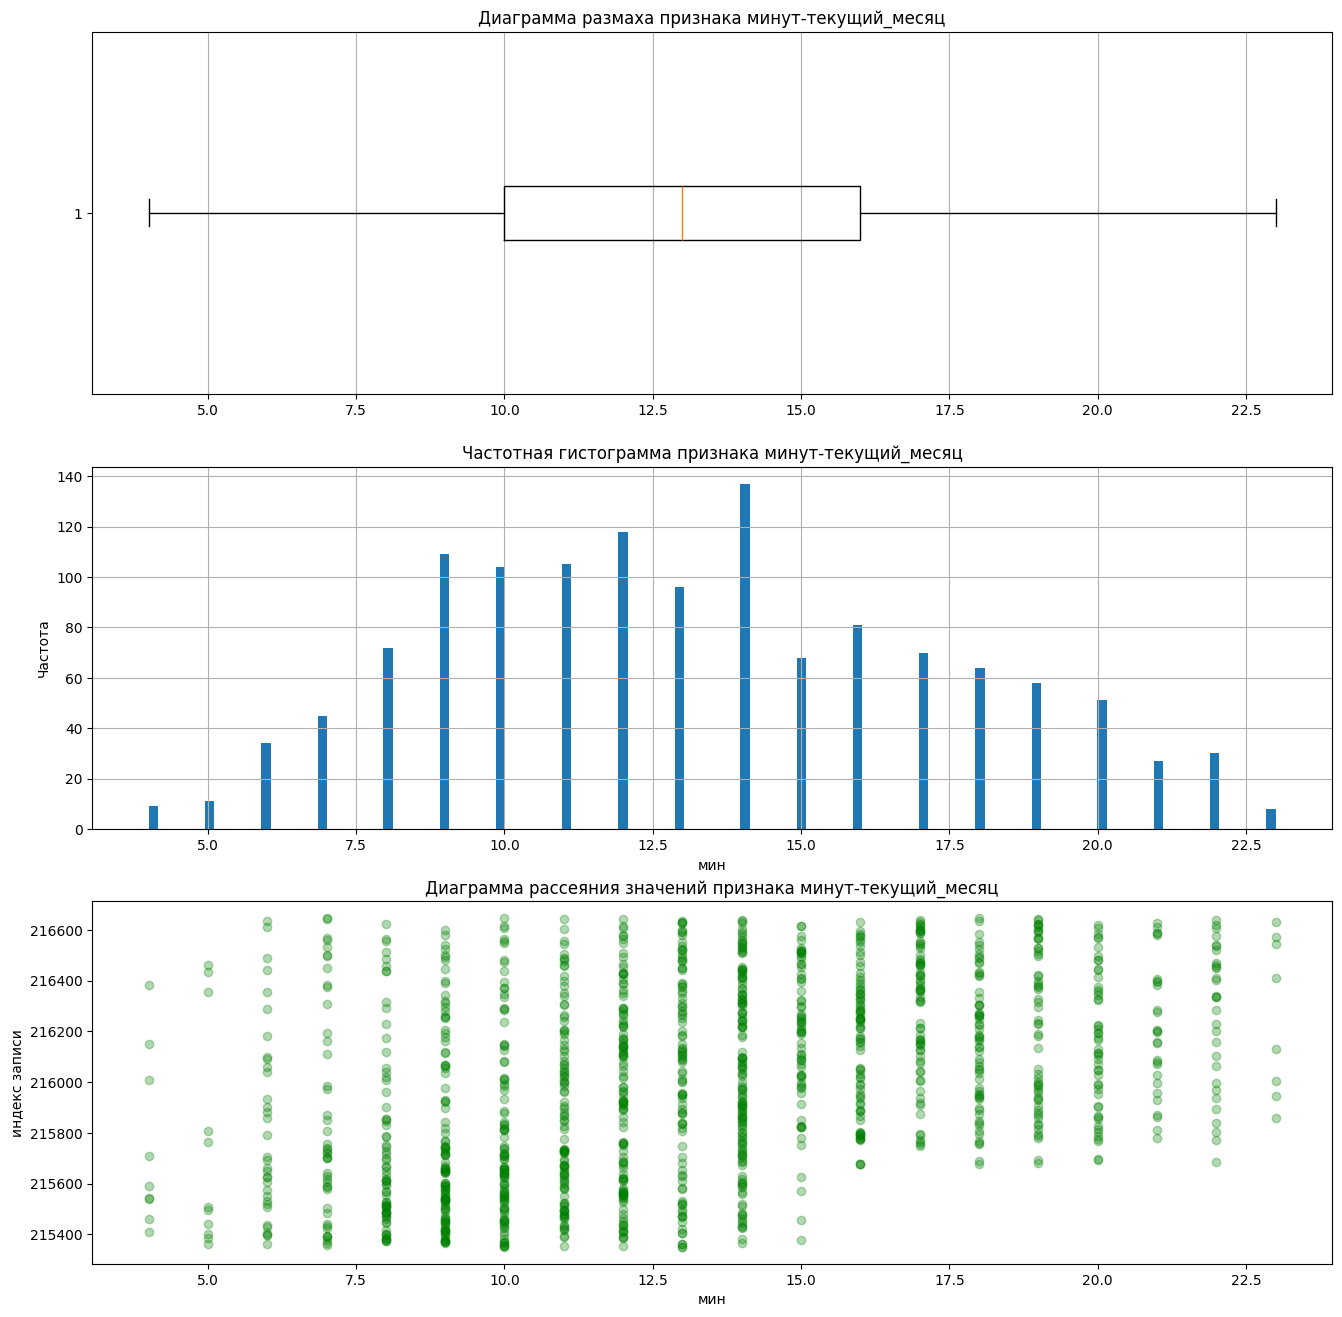

In [233]:
chart_attribute(dataset_market_time['минут_текущий_месяц'], 'минут-текущий_месяц', 'мин',  120)

In [234]:
Anderson(dataset_market_time['минут_текущий_месяц'])

Статистика теста: 7.9592
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


### Набор данных dataset_money, признак 'прибыль'

Рассмотрим спектр значений признака.

In [235]:
data_прибыль = dataset_money['прибыль']
data_прибыль.describe()

count   1,297.00
mean        4.00
std         1.01
min         0.86
25%         3.30
50%         4.04
75%         4.67
max         7.43
Name: прибыль, dtype: float64

Признак - численный.

In [236]:
data_прибыль.nunique()

399

В спектре значений 399 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

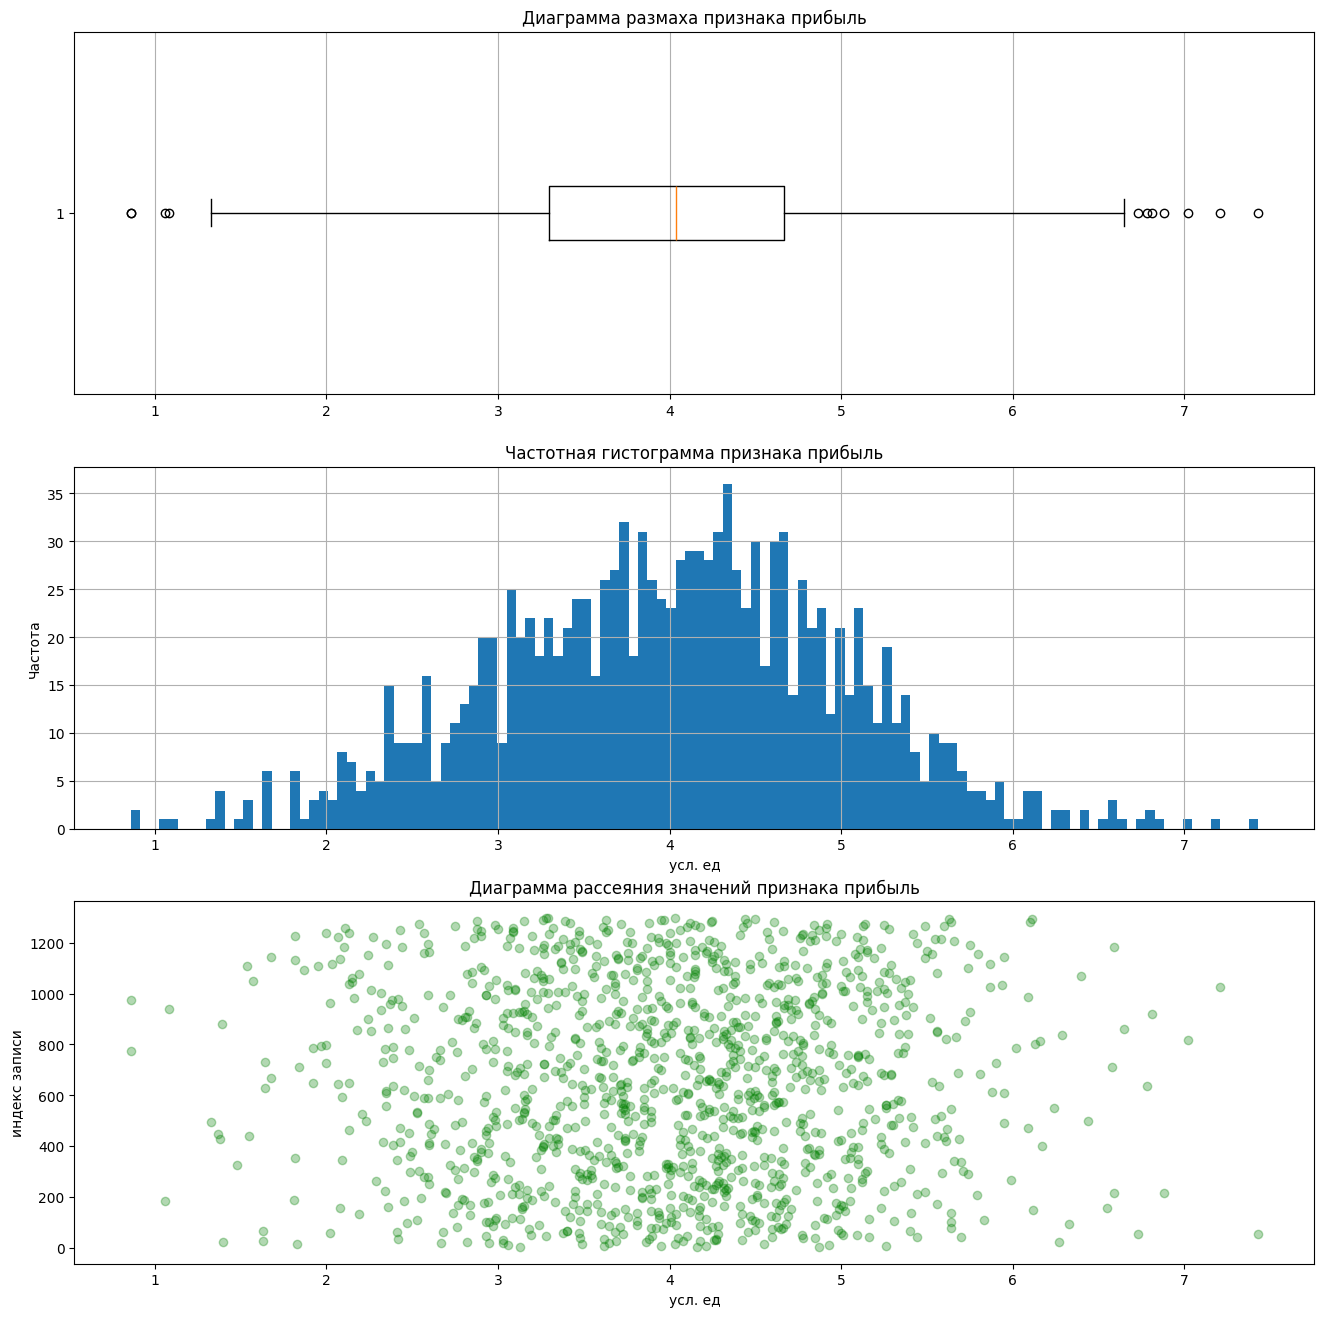

In [237]:
chart_attribute(data_прибыль, 'прибыль', 'усл. ед',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [238]:
Anderson(data_прибыль)

Статистика теста: 0.5896
Критическое значение для 5% уровня значимости: 0.7850
Нет оснований отвергать H0: распределение нормальное (p > 0.05)


Распределение значений признака - нормальное.

## Объединение таблиц

Последовательно объединим наборы данных dataset_market, dataset_market_money и dataset_market_time, ключом объединения будем использовать идентификатор покупателя, а принцип объединения - полное внутренние совпадение.

### Объединение наборов данных dataset_market и dataset_market_money

In [239]:
dataset_market = pd.merge(dataset_market, dataset_market_money, how = 'inner', on = 'id')
dataset_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Объединение наборов данных dataset_market и dataset_market_time

In [240]:
dataset_market = pd.merge(dataset_market, dataset_market_time, how = 'inner', on = 'id')
dataset_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Объединение наборов данных dataset_market и dataset_money

In [241]:
dataset_market = pd.merge(dataset_market, dataset_money, how = 'inner', on = 'id')
dataset_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Обзор подготовленного набора данных dataset_market

В итоге, назначем идентификатор покупателя 'id', индексом набора данных и выведем пятистрочный сэмпл данных.

In [242]:
dataset_market = dataset_market.set_index('id')
dataset_market.sample(5)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
216328           Прежний уровень     премиум                 да   
215919                 Снизилась     премиум                 да   
216604           Прежний уровень    стандарт                 да   
215871           Прежний уровень     премиум                нет   
215988           Прежний уровень    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
216328                4.10                     4           686   
215919                4.30                     3           384   
216604                4.90                     5           350   
215871                4.80                     3           675   
215988                4.40                     3           910   

        акционные_покупки                  популярная_категория  \
id                                                                
216328               0.14        Техника для красоты и здоровья   
215919               0.21  Мелкая бытовая техника и электроника   
216604               0.99                     Домашний текстиль   
215871               0.11                       Кухонная посуда   
215988               0.11        Техника для красоты и здоровья   

        средний_просмотр_категорий_за_визит  \
id                                            
216328                                    2   
215919                                    2   
216604                                    3   
215871                                    2   
215988                                    2   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
216328                                   3               2                10   
215919                                   3               2                 4   
216604                                   4               5                 5   
215871                                   1               7                 4   
215988                                   1               5                15   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
216328                  3,495.00                     4,339.00   
215919                  4,791.50                     4,940.00   
216604                  4,545.00                     4,735.00   
215871                  5,228.00                     5,468.00   
215988                  4,422.00                     4,962.00   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
id                                                                           
216328               4,356.90                      20                   19   
215919               4,792.80                      17                   17   
216604               4,840.10                      14                   14   
215871               5,150.00                      14                   21   
215988               5,021.30                      16                   19   

        прибыль  
id               
216328     2.98  
215919     4.62  
216604     2.88  
215871     4.09  
215988     5.10

In [243]:
dataset_market.sample(5)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
216533           Прежний уровень    стандарт                нет   
216014           Прежний уровень    стандарт                 да   
215493                 Снизилась    стандарт                 да   
215592                 Снизилась     премиум                 да   
215613                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
216533                5.70                     5           769   
216014                4.20                     4           382   
215493                4.00                     5           881   
215592                4.60                     4           486   
215613                4.40                     4           627   

        акционные_покупки                  популярная_категория  \
id                                                                
216533               0.14        Техника для красоты и здоровья   
216014               0.25  Мелкая бытовая техника и электроника   
215493               0.99                       Кухонная посуда   
215592               0.22                      Товары для детей   
215613               0.93        Техника для красоты и здоровья   

        средний_просмотр_категорий_за_визит  \
id                                            
216533                                    4   
216014                                    5   
215493                                    3   
215592                                    3   
215613                                    3   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
216533                                   1               8                10   
216014                                   1               5                 8   
215493                                   5               6                 5   
215592                                   2               3                 2   
215613                                   7               3                 4   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
216533                  5,868.00                     4,925.00   
216014                  5,176.00                     5,140.00   
215493                  6,716.50                     4,870.00   
215592                  4,995.50                     4,643.00   
215613                  3,563.00                     4,457.00   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
id                                                                           
216533               5,180.30                      15                   20   
216014               5,337.20                      19                   16   
215493               7,799.40                       9                   10   
215592               4,877.20                       8                    9   
215613               4,700.50                      11                   12   

        прибыль  
id               
216533     6.59  
216014     4.45  
215493     3.39  
215592     3.30  
215613     5.99

Объединение наборов данных завершено.

## Корреляционный анализ

### Расчёт коэффициентов  $\phi_{K}$ корреляции

In [244]:
intervals_columns = dataset_market.drop('прибыль', axis = 1).select_dtypes('number').columns.tolist()
phik_overview = dataset_market.drop('прибыль', axis = 1).phik_matrix(interval_cols = intervals_columns)
display(phik_overview)

покупательская_активность  тип_сервиса  \
покупательская_активность                                 1.00         0.13   
тип_сервиса                                               0.13         1.00   
разрешить_сообщать                                        0.00         0.29   
маркет_актив_6_мес                                        0.54         0.09   
маркет_актив_тек_мес                                      0.00         0.05   
длительность                                              0.10         0.40   
акционные_покупки                                         0.51         0.03   
популярная_категория                                      0.30         0.07   
средний_просмотр_категорий_за_визит                       0.54         0.19   
неоплаченные_продукты_штук_квартал                        0.51         0.12   
ошибка_сервиса                                            0.22         0.08   
страниц_за_визит                                          0.75         0.10   
выручка_предыдущий_месяц                                  0.22         0.00   
выручка_препредыдущий_месяц                               0.50         0.07   
выручка_текущий_месяц                                     0.20         0.12   
минут_предыдущий_месяц                                    0.69         0.13   
минут_текущий_месяц                                       0.58         0.00   

                                     разрешить_сообщать  маркет_актив_6_мес  \
покупательская_активность                          0.00                0.54   
тип_сервиса                                        0.29                0.09   
разрешить_сообщать                                 1.00                0.00   
маркет_актив_6_мес                                 0.00                1.00   
маркет_актив_тек_мес                               0.05                0.08   
длительность                                       0.25                0.00   
акционные_покупки                                  0.01                0.28   
популярная_категория                               0.07                0.15   
средний_просмотр_категорий_за_визит                0.07                0.21   
неоплаченные_продукты_штук_квартал                 0.20                0.29   
ошибка_сервиса                                     0.02                0.14   
страниц_за_визит                                   0.04                0.40   
выручка_предыдущий_месяц                           0.08                0.16   
выручка_препредыдущий_месяц                        0.00                0.32   
выручка_текущий_месяц                              0.06                0.04   
минут_предыдущий_месяц                             0.04                0.36   
минут_текущий_месяц                                0.00                0.33   

                                     маркет_актив_тек_мес  длительность  \
покупательская_активность                            0.00          0.10   
тип_сервиса                                          0.05          0.40   
разрешить_сообщать                                   0.05          0.25   
маркет_актив_6_мес                                   0.08          0.00   
маркет_актив_тек_мес                                 1.00          0.17   
длительность                                         0.17          1.00   
акционные_покупки                                    0.00          0.00   
популярная_категория                                 0.14          0.00   
средний_просмотр_категорий_за_визит                  0.25          0.19   
неоплаченные_продукты_штук_квартал                   0.14          0.19   
ошибка_сервиса                                       0.12          0.18   
страниц_за_визит                                     0.00          0.12   
выручка_предыдущий_месяц                             0.05          0.13   
выручка_препредыдущий_месяц                          0.00          0.11   
выручка_текущий_месяц                                0.00         

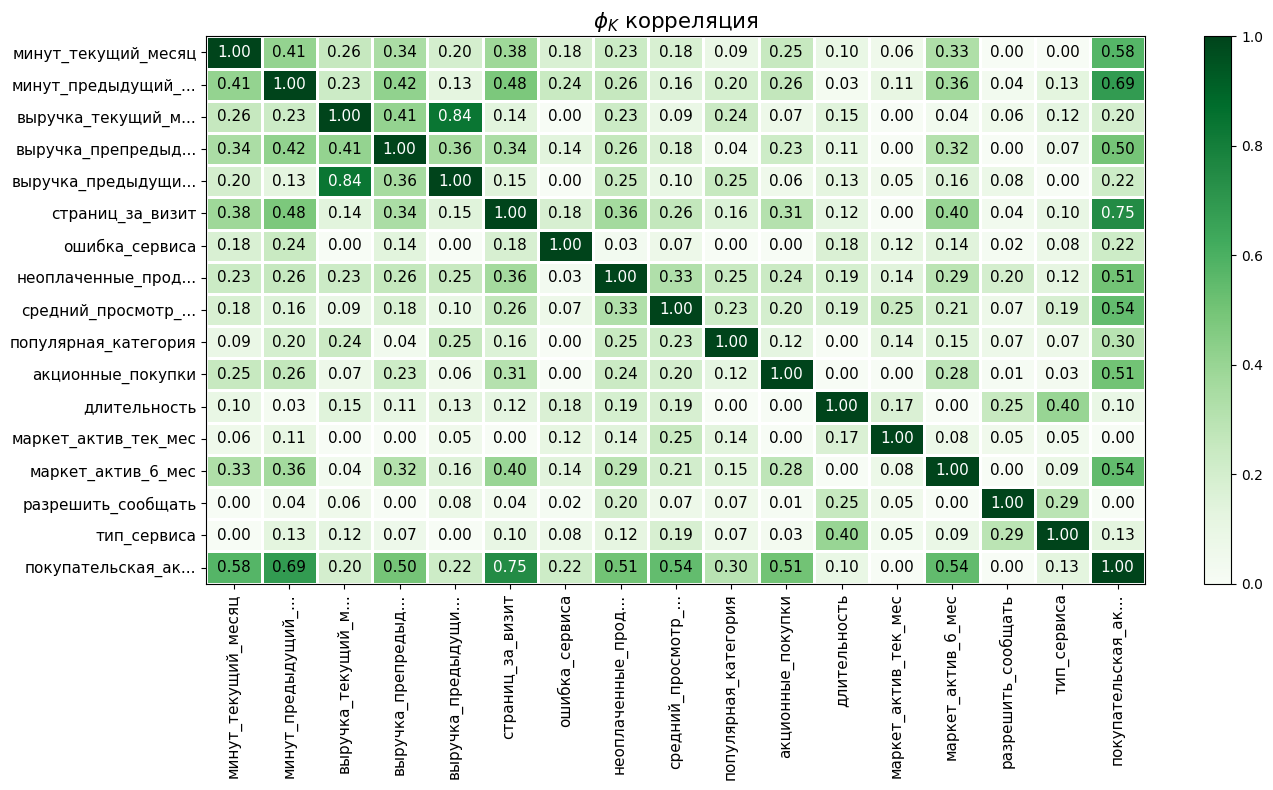

In [245]:
plot_correlation_matrix(phik_overview.values, x_labels = phik_overview.columns, y_labels = phik_overview.index,\
                        vmin = 0, vmax = 1, color_map = 'Greens', title = r'$\phi_{K}$ корреляция', fontsize_factor = 1.1,\
                        figsize = (14, 8))

Наиболее сильная взаимная корреляция наблюдается между признаками 'выручка_предыдущий_месяц' и 'выручка_текущий_месяц'. Значение коэффициента ФиК корреляции - 0.84. Можно считать, мультиколлениарность ниже значения 0.90 - умеренная.

### Расчёт VIF величин

In [246]:
vif_scores = get_vif_scores(dataset_market[intervals_columns])
display(vif_scores)

Признак  VIF
9              выручка_предыдущий_месяц 4.26
11                выручка_текущий_месяц 3.90
10          выручка_препредыдущий_месяц 1.61
12               минут_предыдущий_месяц 1.53
8                      страниц_за_визит 1.42
13                  минут_текущий_месяц 1.32
1                    маркет_актив_6_мес 1.22
6    неоплаченные_продукты_штук_квартал 1.20
4                     акционные_покупки 1.19
5   средний_просмотр_категорий_за_визит 1.18
3                          длительность 1.10
7                        ошибка_сервиса 1.08
2                  маркет_актив_тек_мес 1.04

Мультиколлениарность слабая, почти все величины лежат в диапазоне от 1 до 2.

Выделяются те же признаки: 'выручка_предыдущий_месяц' и 'выручка_текущий_месяц'. Значения близки к 5, хотя и ниже.

Величин выше 5 - нет. То есть, можно утведждать, что признаков с сильной мультиколлениарностью - нет.

### Ранжирование признаков по статистическому влиянию на целевой признак

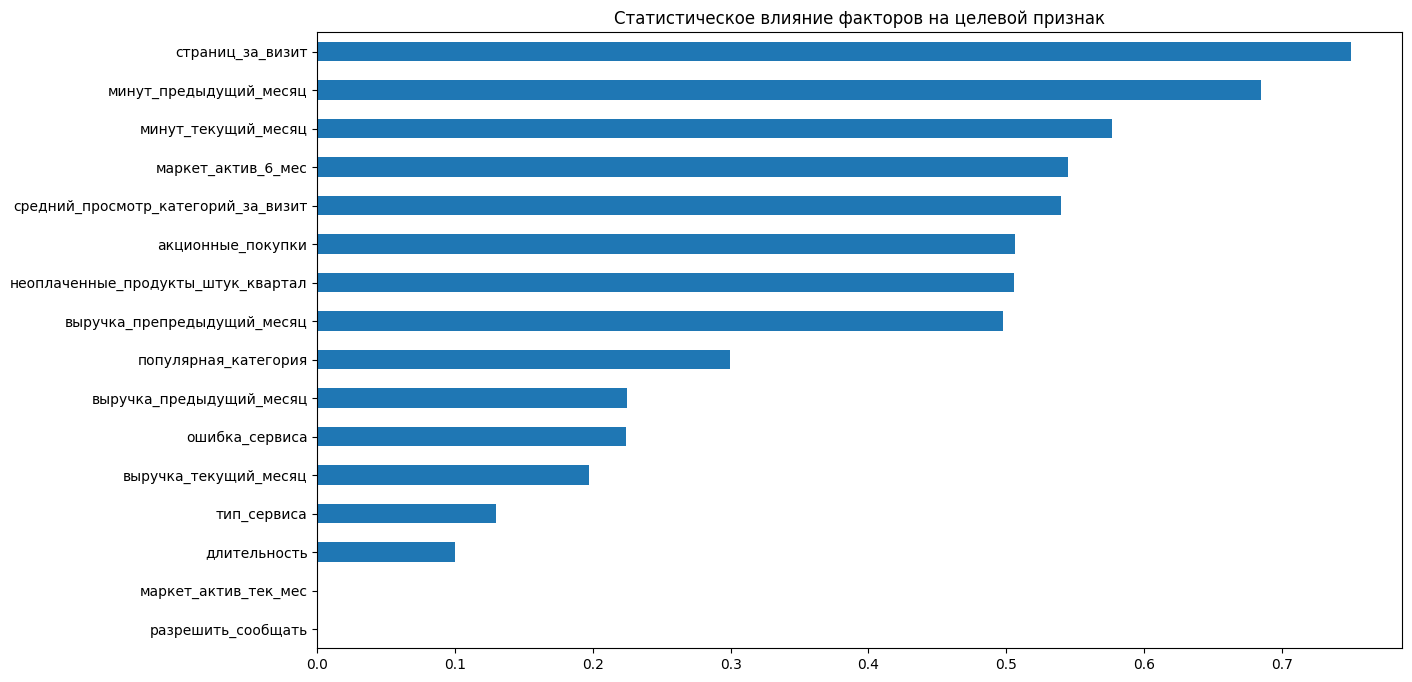

In [247]:
plt.figure(figsize = (14, 8))
plt.title('Статистическое влияние факторов на целевой признак')
plt.grid(visible = True, axis = 'x')
phik_overview['покупательская_активность'].sort_values(ascending = True)[:-1].plot(kind = 'barh')
plt.show()

Признаки 'разрешить_сообщать' и 'маркет_актив_тек_мес' практически не имеют статистического влияния на целевой признак.

## Использование пайплайнов

### Деление набора данных на тренировочную и тестовую выборки

Разделим набор данных на тренировочную и тестовую выборки. Из тренировочных данных удалим целевой признак 'покупательская_активность' и ненужный в машинном обучении признак 'прибыль'. Идентификатор клиента 'id' мы уже назначили индексом в наборе данных.

In [248]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_market.drop(['покупательская_активность', 'прибыль'], axis = 1),
    dataset_market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = dataset_market['покупательская_активность'])

### Кодирование целевого признака в тренировочной и тестовой выборках

Для автоматического кодирования текстовых значений целевого признака, применим LabelEncoder.

In [249]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Выведем результат кодирования. Соответствие цифровых и текстовых значений целевого признака.

In [250]:
pred_classes = np.unique(y_test)
print('Значения признака до кодирования: ', pred_classes)
print('Значения признака после кодирования: ', label_encoder.inverse_transform(pred_classes))

Значения признака до кодирования:  [0 1]
Значения признака после кодирования:  ['Прежний уровень' 'Снизилась']


### Распределение признаков по автоматическим операциям кодирования и масштабирования

Явное разделим признаки по типам кодирования и масштабирования.

In [251]:
# признаки для кодирования OneHotEncoder
ohe_columns = [
    'популярная_категория',
    'разрешить_сообщать'
]

# признаки для кодирования OrdinalEncoder
ord_columns = [
    'тип_сервиса' 
]

# признаки для масштабирования
num_columns = [
    'средний_просмотр_категорий_за_визит',
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'страниц_за_визит',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'выручка_предыдущий_месяц',
    'минут_текущий_месяц',
    'минут_предыдущий_месяц'
]

### Конструирование пайплайнов-компонентов

Пайплайн one_hot кодирования категориальных данных.

In [252]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ohe', OneHotEncoder(drop = 'first', handle_unknown='error', sparse_output = False))
    ])

Пайплайн порядкового кодирования категориальных данных.

In [253]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ord',  OrdinalEncoder(categories = [['стандарт', 'премиум']], handle_unknown = 'use_encoded_value',\
                             unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
    ])

Пайплайн-трансформер препроцессинга данных.

In [254]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough')

Пайплайн-коллектор данных.

In [255]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    #('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = 10))),
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
])

In [256]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strateg...
                                                  ['средний_просмотр_категорий_за_визит',
                                                   'акционные_покупки',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'страниц_за_визит',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'выручка_предыдущий_месяц',
                                                   'минут_текущий_месяц',
                                                   'минут_предыдущий_месяц'])])),
                ('models', DecisionTreeClassifier(random_state=27466437))])

Конструкция собрана.

### Перебор гиперпараметров через случайный кросс-валидатор

Используем четыре модели линейной классификации:
 - DecisionTreeClassifier - решающее дерево;
 - KNeighborsClassifier - k ближайших соседей;
 - LogisticRegression - логистическая регрессия;
 - SupportVectorClassifier - опорные вектора.

Составим список из четырёх словарей, по словарю на модель. В словарях, в виде пары ключ-значение, перечислим гиперпараметры моделей.

In [257]:
param_grid = [
    # словарь для модели LogisticRegressionClassifier
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [LogisticRegression(
            random_state = RANDOM_STATE,
            solver = 'liblinear',
            penalty = 'l1',
            class_weight = 'balanced'
        )],
        'models__C': [0.01, 0.1, 1, 10],
        'models__max_iter': [1000, 2000, 3000]
    },
    
    # словарь для модели SupportVectorClassifier
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [SVC(
            kernel = 'poly',
            random_state = RANDOM_STATE,
            gamma = 'auto',
            probability = True,
            class_weight = 'balanced'
        )],
        'models__degree': range(2, 8),
        'models__C': [0.01, 0.1, 1, 10]
    },

    # словарь для модели DecisionTreeClassifier
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__max_features': range(1, 20),
        'models__min_samples_split': range(2, 10)
    },
    
    # словарь для модели KNeighborsClassifier 
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20)
    }
]

Составим словарь из метрик, по которым будет оцениваться качество моделей в кросс-валидаторе. Используем метрику Recall, как показатель минимизации ложно-отрицательных прогнозов, среднее гармоническое F1 между Recall и Precission и ROC-AUC, как показатель уверенности разделения классов.

Если, в итоге, модель будет уверенно разделять клиентов интернет-магазина на лояльных и нелояльных, но будет часто незамечать клиентов склонных к снижению покупательской активности, ложно классифицируя их как клиентов с прежней активностью, то ценность модели с точки зрения бизнеса будет под большим вопросом.

Итак, создадим объект модели случайного кросс-валидатора RandomizedSearchCV и инициализируем его пайплайном-коллектором данных pipe_final, списком гиперпараметров param_grid и списком метрик scoring. Запустим объект randomized_search, методом fit на поиск лучшего сочетания модель/гиперпараметры. В качестве финальной оценки результата, используем метрику roc_auc.

Поиск занимает больше двух минут.

In [258]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    verbose = 2,
    n_iter = 400,
    random_state = RANDOM_STATE,
    #refit = 'recall',
    cv = 5,
    scoring = 'roc_auc', #scoring,
    n_jobs = -1
)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.3s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.2s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.1s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.1s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория',
                                                                                'разрешить_сообщать']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer...
                                         'models__max_features': range(1, 20),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               RobustScaler(),
                                                               StandardScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               RobustScaler(),
                                                               StandardScaler(),
                                                               'passthrough']}],
                   random_state=27466437, scoring='roc_auc', verbose=2)

Результаты перебора гиперпараметров кросс-валидатором.

In [259]:
best_model_pipeline = randomized_search.best_estimator_
best_model_params = randomized_search.best_params_
best_model_score = randomized_search.best_score_
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
train_score = randomized_search.score(X_train, y_train)
test_score = randomized_search.score(X_test, y_test)

#selected_features = best_model_pipeline.named_steps['preprocessor'].get_feature_names_out()[best_model_pipeline.\
#                                                                        named_steps['feature_selection'].get_support()]

print('Лучшие параметры:\n', best_model_params)
print(f'refit метрика: {randomized_search.refit}')      
print (f'Лучшая точность на кросс-валидации: {best_model_score:.4f}')
print('************************************************')
print(f'Точность на тренировочных данных: {train_score:.4f}')
print(f'Точность на тестовых данных: {test_score:.4f}')
print(f'Accuracy на тестовых данных: {accuracy_score(y_test, y_test_pred):.4f}')
print(f'Recall на тренировочных данных: {recall_score(y_train, randomized_search.predict(X_train)):.4f}')
print(f'Recall на тестовых данных: {recall_score(y_test, y_test_pred):.4f}')
print(f'ROC-AUC на тестовых данных: {roc_auc_score(y_test, y_test_proba):.4f}')
#print('************************************************')
#print(f"Выбранные признаки: {selected_features}")

Лучшие параметры:
 {'preprocessor__num': MinMaxScaler(), 'models__max_iter': 2000, 'models__C': 1, 'models': LogisticRegression(class_weight='balanced', penalty='l1', random_state=27466437,
                   solver='liblinear')}
refit метрика: True
Лучшая точность на кросс-валидации: 0.9000
************************************************
Точность на тренировочных данных: 0.9102
Точность на тестовых данных: 0.9140
Accuracy на тестовых данных: 0.8642
Recall на тренировочных данных: 0.8005
Recall на тестовых данных: 0.8130
ROC-AUC на тестовых данных: 0.9140


### Обзор параметров лучшей подобранной модели классификации

Лучшие линейные модели, их рейтинги и метрики в кросс-валидаторе.

In [131]:
results = pd.DataFrame(randomized_search.cv_results_)
results['модель'] = results['param_models'].apply(lambda x: x.__class__.__name__)
detailed_names = {
    'mean_score_time': 'время_предсказания',
    'mean_test_recall': 'метрика_recall_на_кроссвалидации',
    'rank_test_recall': 'место_по_метрике_recall',
    'mean_test_roc_auc': 'метрика_roc_auc_на_кроссвалидации',
    'rank_test_roc_auc': 'место_по_метрике_roc_auc'
}
results_renamed = results.rename(columns = detailed_names)
best_models = results_renamed.sort_values('место_по_метрике_roc_auc').groupby('модель').first() #.reset_index()
display(best_models[['время_предсказания',\
                     'место_по_метрике_roc_auc',\
                     'место_по_метрике_recall',\
                     'метрика_roc_auc_на_кроссвалидации',\
                     'метрика_recall_на_кроссвалидации']])

время_предсказания  место_по_метрике_roc_auc  \
модель                                                                 
DecisionTreeClassifier                0.05                         4   
KNeighborsClassifier                  0.10                         3   
LogisticRegression                    0.20                         1   

                        место_по_метрике_recall  \
модель                                            
DecisionTreeClassifier                      104   
KNeighborsClassifier                        381   
LogisticRegression                            1   

                        метрика_roc_auc_на_кроссвалидации  \
модель                                                      
DecisionTreeClassifier                               0.87   
KNeighborsClassifier                                 0.87   
LogisticRegression                                   0.90   

                        метрика_recall_на_кроссвалидации  
модель                                                    
DecisionTreeClassifier                              0.74  
KNeighborsClassifier                                0.60  
LogisticRegression                                  0.80

Результат перебора:
 - лучший классификатор - Логистическая регрессия с балансировкой весов классификации и LASSO регуляризацией;
 - лучший препроцессор - Масштабатор по минимальным/максимальным значениям.

### Ручная регулировка метрики Recall лучшей модели

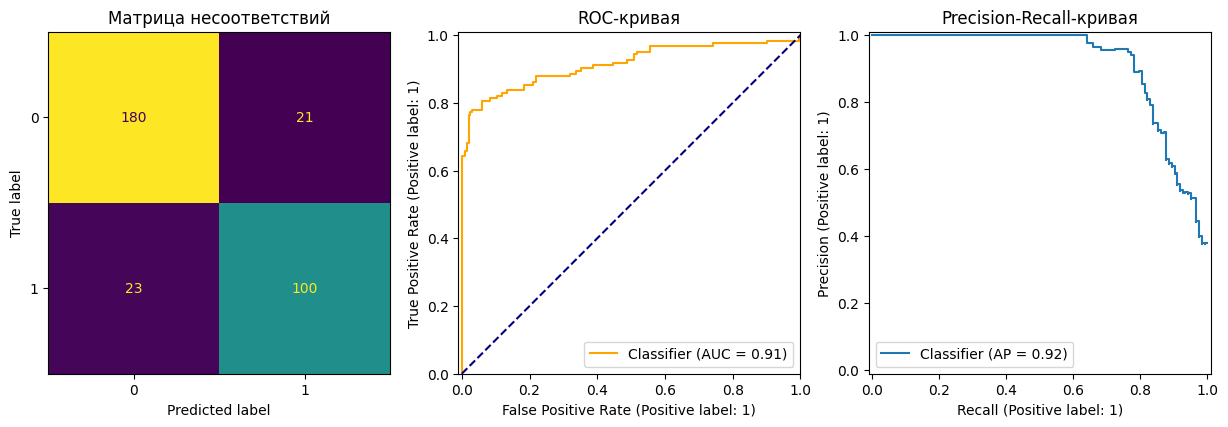

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       201
           1       0.83      0.81      0.82       123

    accuracy                           0.86       324
   macro avg       0.86      0.85      0.86       324
weighted avg       0.86      0.86      0.86       324



In [132]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    ax = axes[0],
    colorbar = False,
)
axes[0].set(title = 'Матрица несоответствий')

RocCurveDisplay.from_predictions(
    y_test, y_test_proba,
    ax = axes[1],
    color = 'orange',
)
axes[1].plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
axes[1].set(title = 'ROC-кривая', xlim = (-0.01, 1), ylim = (0, 1.01))

PrecisionRecallDisplay.from_predictions(
    y_test, y_test_proba,
    ax = axes[2],
)
axes[2].set(title = 'Precision-Recall-кривая')

plt.show()

print(classification_report(y_test, y_test_pred))

Реально увеличить значение метрики Recall, но за счёт снижения метрик Accuracy и Precision. Найдём порог, где Recall больше либо 0.9, а Precision всё ещё не ниже 0.5.

In [133]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)
idx = np.where((recalls[:-1] >= 0.9) & (precisions[:-1] >= 0.5))[0][-1]
optimal_threshold = thresholds[idx]
print('Оптимальный порог вероятности: {0:.5f}'.format(optimal_threshold))
print('Соответствующая порогу метрика Recall: {0:.2f}'.format(recalls[idx]))
print('Соответствующая порогу метрика Precision: {0:.2f}'.format(precisions[idx]))
# Применяем порог
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

Оптимальный порог вероятности: 0.24092
Соответствующая порогу метрика Recall: 0.90
Соответствующая порогу метрика Precision: 0.61


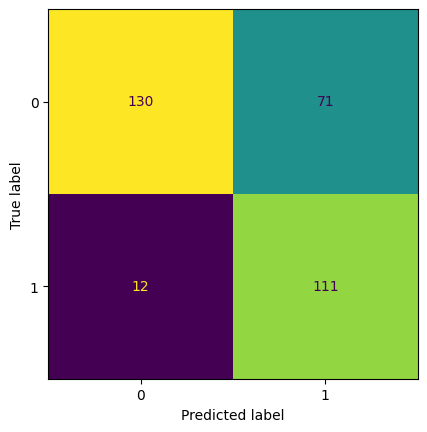

              precision    recall  f1-score   support

           0       0.92      0.65      0.76       201
           1       0.61      0.90      0.73       123

    accuracy                           0.74       324
   macro avg       0.76      0.77      0.74       324
weighted avg       0.80      0.74      0.75       324



In [134]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    colorbar = False,
)
plt.show()
print(classification_report(y_test, y_test_pred))

Как видим, понижая порог вероятности, гораздо быстрее растёт количество ложно-положительных прогнозов, чем снижается количество ложно-отрицательных. Думаю, что снижать порог вероятности классификации даже до уровня 0.24 - неразумно. Всё таки, решение где дополнительные 50 покупателей ошибочно идентифицированых, как 'теряющих лояльность', взамен 11 дополнительных покупателей с реальным снижением лояльности, замеченных системой, может быть неприемлимым. Решение за заказчиком.

## Анализ важности признаков

### Выделение обработанных значений признаков и лучшей обученной модели из случайного кросс-валидатора

In [135]:
fitted_model = best_model_pipeline.named_steps['models']
fitted_preprocessor = best_model_pipeline.named_steps['preprocessor']
feature_names = fitted_preprocessor.get_feature_names_out()
X_train_transformed = fitted_preprocessor.transform(X_train)
X_test_transformed = fitted_preprocessor.transform(X_test)
X_train_preprocessed = pd.DataFrame(X_train_transformed, columns = feature_names)
X_test_preprocessed = pd.DataFrame(X_test_transformed, columns = feature_names)
X_train_preprocessed.sample(5)

ohe__популярная_категория_Косметика и аксесуары  \
161                                             0.00   
536                                             0.00   
583                                             1.00   
247                                             0.00   
739                                             1.00   

     ohe__популярная_категория_Кухонная посуда  \
161                                       0.00   
536                                       0.00   
583                                       0.00   
247                                       0.00   
739                                       0.00   

     ohe__популярная_категория_Мелкая бытовая техника и электроника  \
161                                                            0.00   
536                                                            0.00   
583                                                            0.00   
247                                                            1.00   
739                                                            0.00   

     ohe__популярная_категория_Техника для красоты и здоровья  \
161                                                      0.00   
536                                                      0.00   
583                                                      0.00   
247                                                      0.00   
739                                                      0.00   

     ohe__популярная_категория_Товары для детей  ohe__разрешить_сообщать_нет  \
161                                        1.00                         0.00   
536                                        0.00                         1.00   
583                                        0.00                         0.00   
247                                        0.00                         0.00   
739                                        0.00                         0.00   

     ord__тип_сервиса  num__средний_просмотр_категорий_за_визит  \
161              0.00                                      0.80   
536              0.00                                      0.20   
583              0.00                                      0.60   
247              0.00                                      0.00   
739              0.00                                      0.60   

     num__акционные_покупки  num__неоплаченные_продукты_штук_квартал  \
161                    0.22                                     0.10   
536                    0.33                                     0.70   
583                    0.06                                     0.00   
247                    0.10                                     0.00   
739                    0.00                                     0.20   

     num__ошибка_сервиса  num__маркет_актив_6_мес  num__маркет_актив_тек_мес  \
161                 0.67                     0.74                       0.00   
536                 0.89                     0.61                       1.00   
583                 0.56                     0.61                       0.00   
247                 0.56                     0.53                       0.50   
739                 0.22                     0.58                       1.00   

     num__длительность  num__страниц_за_визит  \
161               0.61                   0.42   
536               0.78                   0.21   
583               0.67                   0.32   
247               0.36                   0.26   
739               0.85                   0.26   

     num__выручка_препредыдущий_месяц  num__выручка_текущий_месяц  \
161                              0.44                        0.44   
536                              0.30                        0.74   
583                              0.29                        0.34   
247                              0.45                        0.58   
739                              0.56                        0.67   

     num__выручка_предыдущий_месяц  num__

### Оценка коэффициентов обученной модели при признаках

<Axes: ylabel='Feature'>

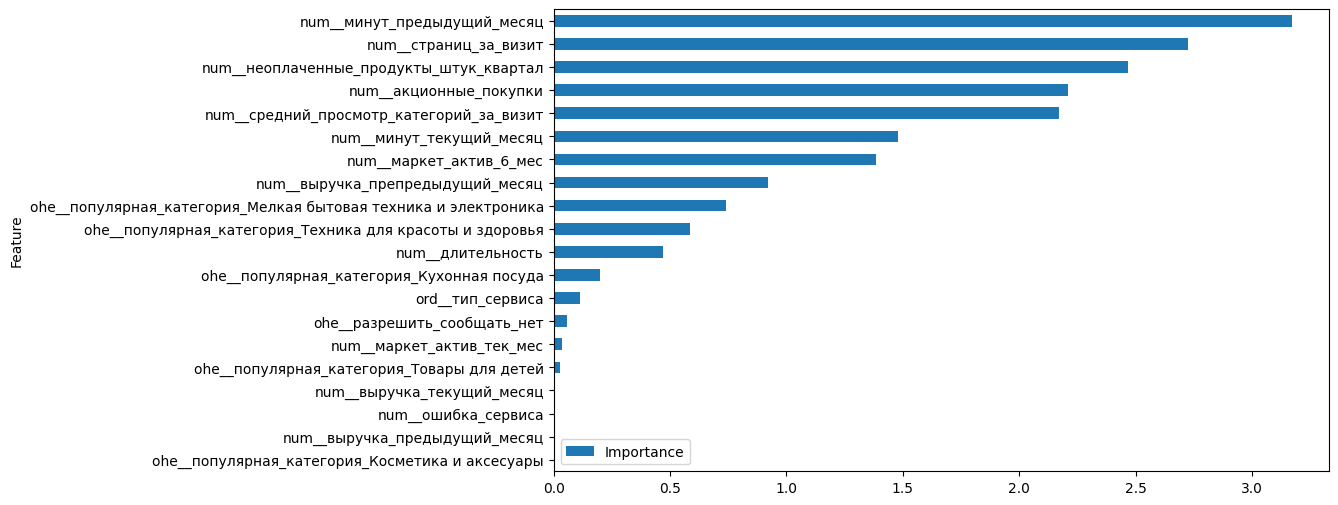

In [136]:
coefficients = fitted_model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending = True)
feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (10, 6))

Наиболее влияющие коэффициенты при следующих признаках:
 - минут_предыдущий_месяц
 - страниц_за_визит
 - неоплаченные_продукты_штук_квартал
 - акционные_покупки
 - средний_просмотр_категорий_за_визит

### Анализ SHAP значений

In [137]:
explainer = shap.LinearExplainer(fitted_model, X_train_preprocessed, feature_perturbation = 'correlation_dependent')
shap_values = explainer(X_test_preprocessed)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Построим диаграмму общих вкладов признаков в прогноз модели.

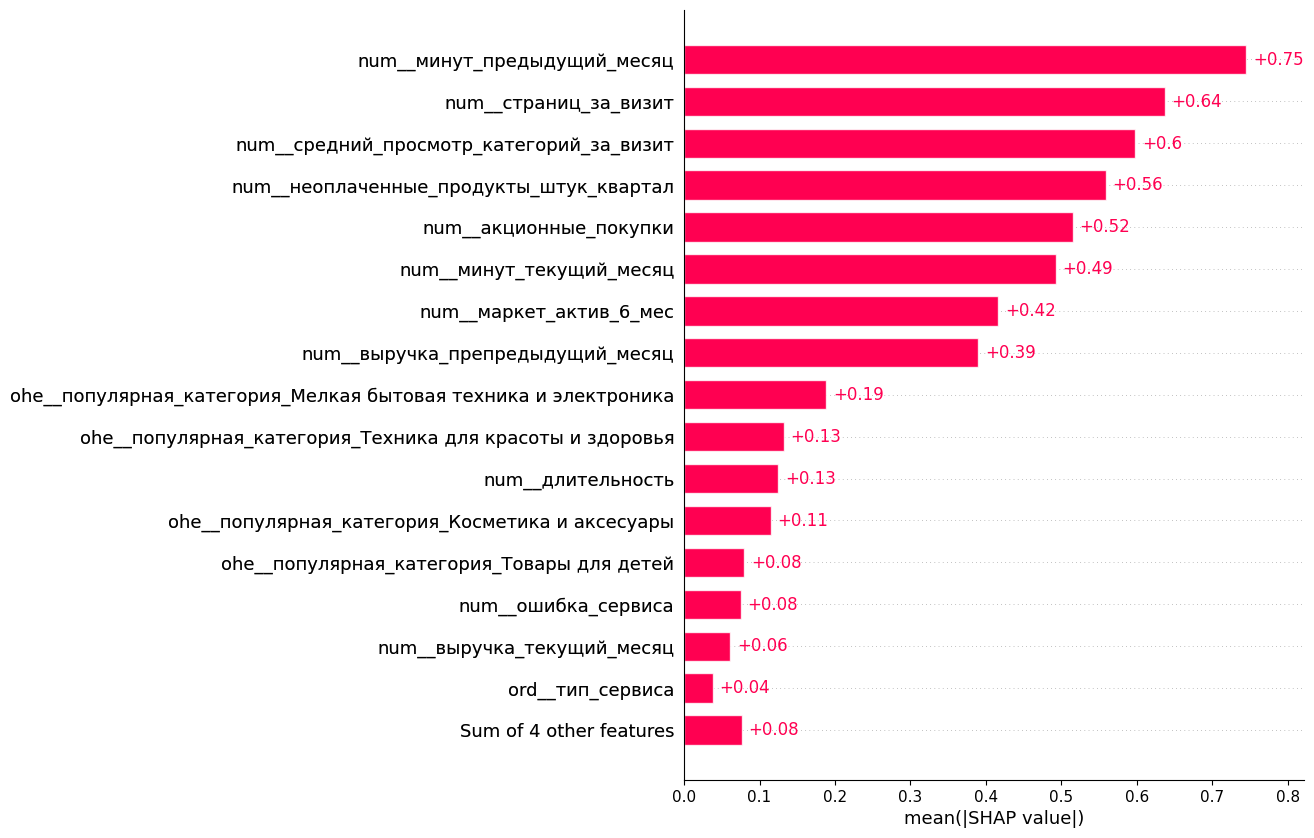

In [138]:
shap.plots.bar(shap_values, max_display=17)

Восемь верхних признаков имеют выраженно большее абсолютное влияние на прогнозы модели:
 - минут_предыдущий_месяц
 - страниц_за_визит
 - средний_просмотр_категорий_за_визит
 - неоплаченные_продукты_штук_квартал
 - акционные_покупки
 - присутствие_минут_текущий_месяц
 - маркет_актив\_6\_мес
 - выручка_препредыдущий_месяц
 
 

Построим график влияния признаков на прогноз классификации модели.

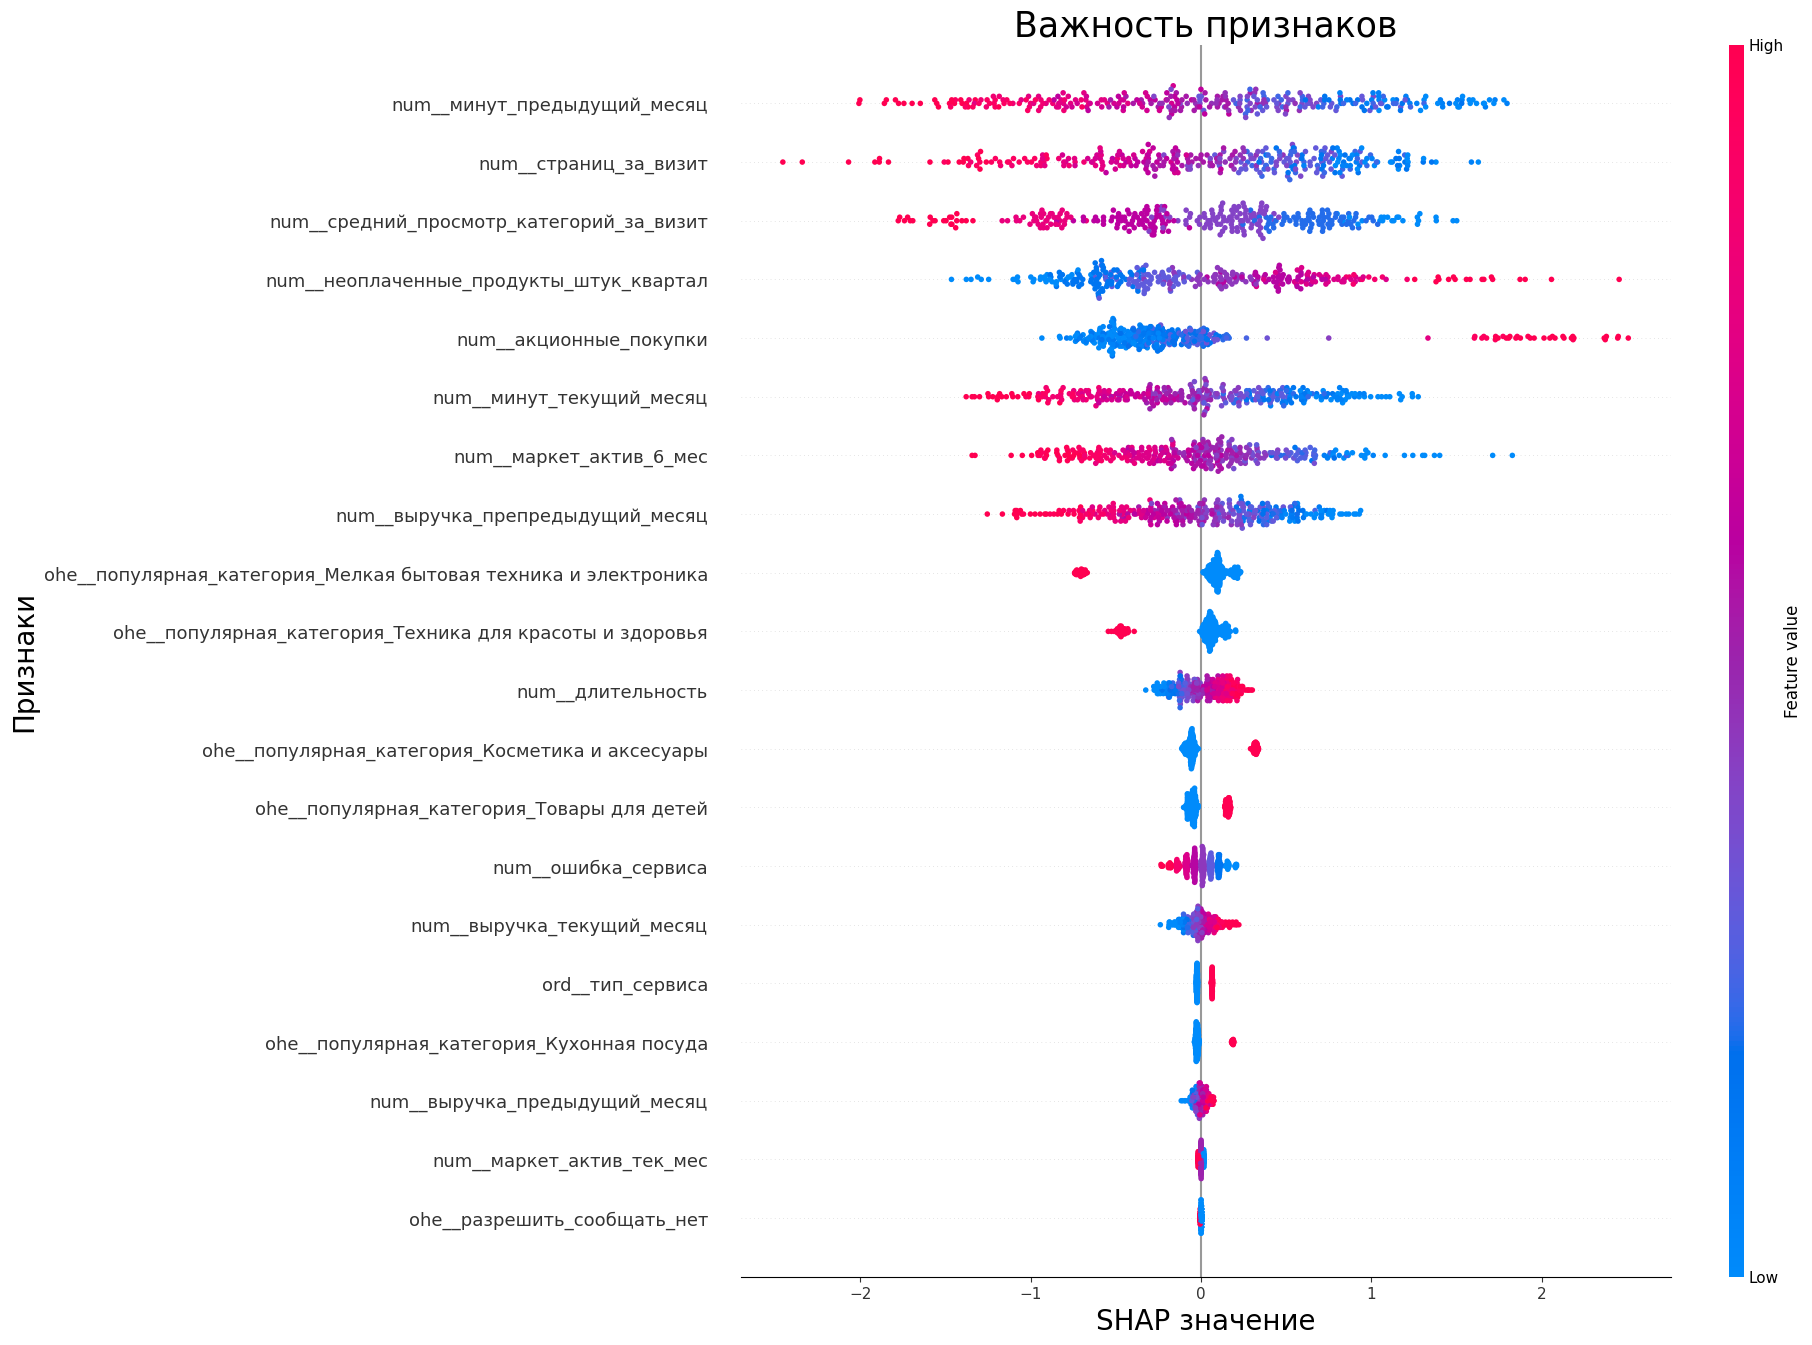

In [139]:
shap.plots.beeswarm(
    shap_values,
    plot_size=(17, 17),
    max_display=30,
    show=False   
)
plt.title('Важность признаков', fontsize=25)
plt.xlabel('SHAP значение', fontsize=20)
plt.ylabel('Признаки', fontsize=20)
plt.gcf().set_size_inches(15, 16) 
plt.show()

Напомним себе, что наименование класса "снизилась" - это наша целевая группа покупателей, которая теряет активность.

Очевидно, что только часть признаков обладающих влиянием на прогноз модели может поддаваться прямому воздействию.
 - неоплаченные_продукты_штук_квартал - высокие количества неоплаченых товаров в корзине, мощно склоняют модель к классификации 'снизилась';
 - акционные_покупки - высокая доля в покупках акционных товаров, мощно склоняет модель к классификации 'снизилась';
 - маркет_актив\_6\_мес - низкое количество контактов с покупателем в течении полугода, умерено склоняет модель к классификации 'снизилась'.
 
Некоторые признаки, можно использовать, как индикаторы роста вероятности снижения покупательской активности.
 - минут_предыдущий_месяц - малые количества времени проводимые покупателем в интернет-магазине в прошлом месяце, мощно склоняют модель к классификации 'снизилась';
 - страниц_за_визит - малые колличества просматриваемых покупателем страниц интернет-магазина за визит, мощно склоняют модель к классификации 'снизилась';
 - средний_просмотр_категорий_за_визит- малые колличества просматриваемых покупателем категорий товаров за визит, мощно склоняют модель к классификации 'снизилась';
 - минут_текущий_месяц - малые количества времени проводимые покупателем в интернет-магазине в текущем месяце, мощно склоняют модель к классификации 'снизилась'.

## Сегментация покупателей

Снова выделим набор значений признаков X, как в п.7.1, но без разделения на тренировочную и тестовую выборки. Используя лучшую обученную линейную модель, рассчитаем вероятности снижения активности покупателей и добавим их в набор данных dataset_market, как новый признак 'вероятность'.

In [140]:
X = dataset_market.drop(['покупательская_активность', 'прибыль'], axis=1)
dataset_market['вероятность'] = fitted_model.predict_proba(fitted_preprocessor.transform(X))[:, 1]
dataset_market.sample(5)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
216620           Прежний уровень    стандарт                 да   
216218           Прежний уровень    стандарт                 да   
216607           Прежний уровень    стандарт                 да   
215984           Прежний уровень    стандарт                 да   
216541           Прежний уровень    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
216620                6.10                     4          1001   
216218                5.80                     4           345   
216607                3.30                     4           575   
215984                4.10                     4           913   
216541                4.10                     4           593   

        акционные_покупки            популярная_категория  \
id                                                          
216620               0.17                Товары для детей   
216218               0.12  Техника для красоты и здоровья   
216607               0.23                Товары для детей   
215984               0.28                 Кухонная посуда   
216541               0.29           Косметика и аксесуары   

        средний_просмотр_категорий_за_визит  \
id                                            
216620                                    3   
216218                                    5   
216607                                    2   
215984                                    2   
216541                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
216620                                   5               6                19   
216218                                   3               3                 9   
216607                                   4               5                 8   
215984                                   2               4                 7   
216541                                   1               1                 8   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
216620                  5,486.00                     5,396.00   
216218                  5,378.50                     5,317.00   
216607                  4,991.00                     4,463.00   
215984                  5,529.50                     4,781.00   
216541                  5,782.00                     4,432.00   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
id                                                                           
216620               5,538.00                      17                   20   
216218               5,561.80                       7                   12   
216607               5,578.60                      11                   12   
215984               6,308.20                      15                   14   
216541               7,082.00                      18                   22   

        прибыль  вероятность  
id                            
216620     5.25         0.05  
216218     4.40         0.19  
216607     4.91         0.83  
215984     4.31         0.54  
216541     5.75         0.12

### Критерий сегментирования - покупательская активность

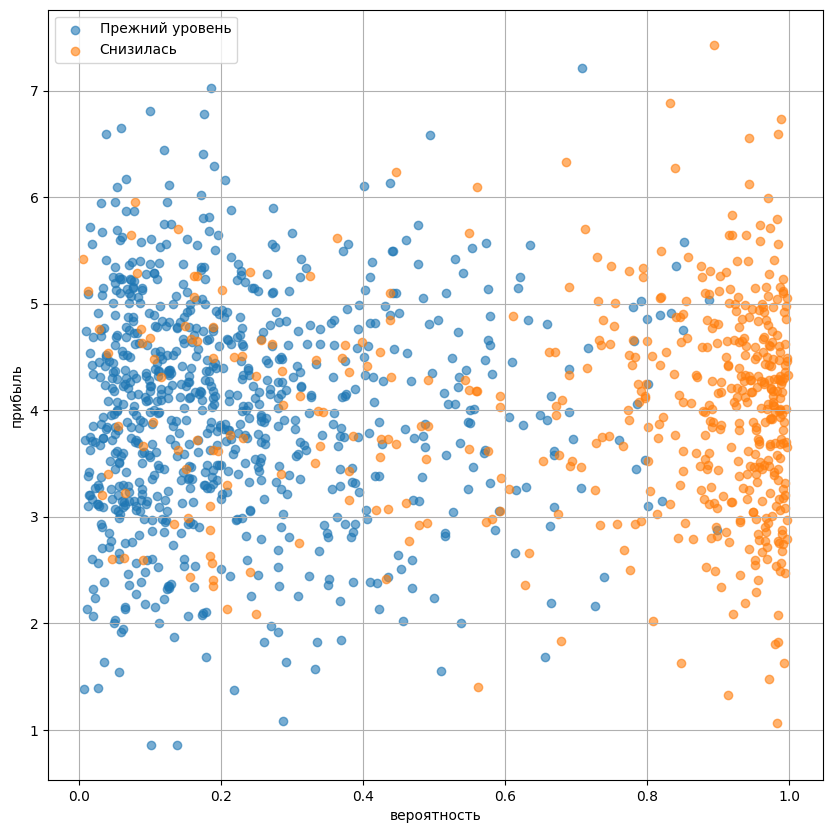

In [141]:
scatter_attr(dataset_market, 'покупательская_активность')

Модель действительно, довольно точно предсказывает класс целевого признака. На диаграмме отчётливо локализованы ядра областей значений целевого признака 'покупательская_активность':
 - для значений 'Прежний уровень', диапазон вероятностей 0.0 - 0.2;
 - для значений 'Снизилась', диапазон вероятностей 0.9 - 1.0;
 
Прибыль, для обеих категорий покупателей сохраняет нормальность распределений, как было показано в п. 4.20. 

### Критерий сегментирования - тип сервиса

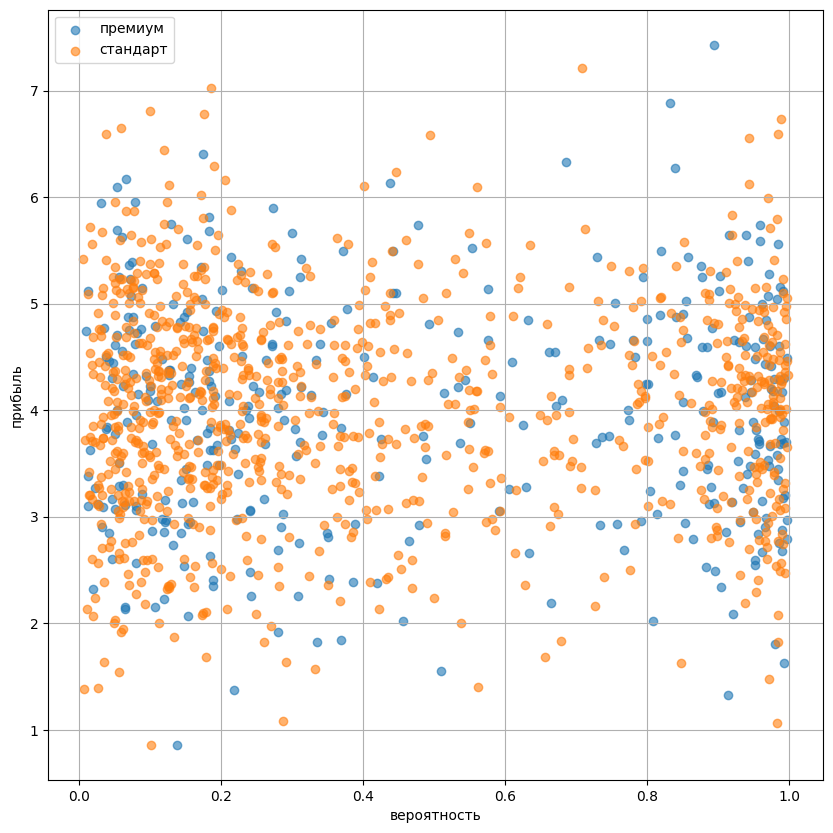

In [142]:
scatter_attr(dataset_market, 'тип_сервиса')

Как видим, значения признака Тип_сервиса хаотично перемешаны вдоль оси 'Вероятность'. Сегментирование по этому признаку бессмысленно.

### Критерий сегментирования - разрешить сообщать

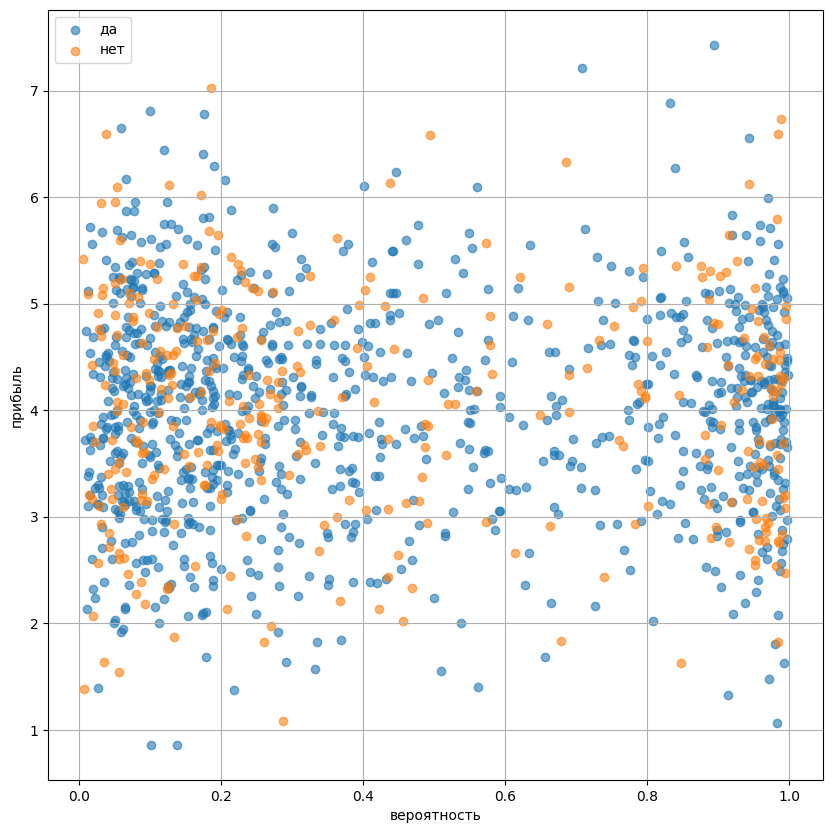

In [143]:
scatter_attr(dataset_market, 'разрешить_сообщать')

Данный признак, даже не включался в тренировочную выборку. Как ключ сегментации, этот признак бесполезен.

### Критерий сегментирования - маркет_актив\_6\_мес

Разделим спектр значений признака на три диапазона.

In [144]:
порог_1_уровень_маркет_активность = 3
порог_2_уровень_маркет_активность = 5
def level_classifier(value):
    if value < порог_1_уровень_маркет_активность:
        return 'низкий'
    elif value > порог_2_уровень_маркет_активность:
        return 'высокий'
    else:
        return 'средний'
    
dataset_market['маркет_актив_6_мес_3_кат'] = dataset_market['маркет_актив_6_мес'].\
map(level_classifier)

И уже по преобразованному признаку построим диаграмму рассеяния.

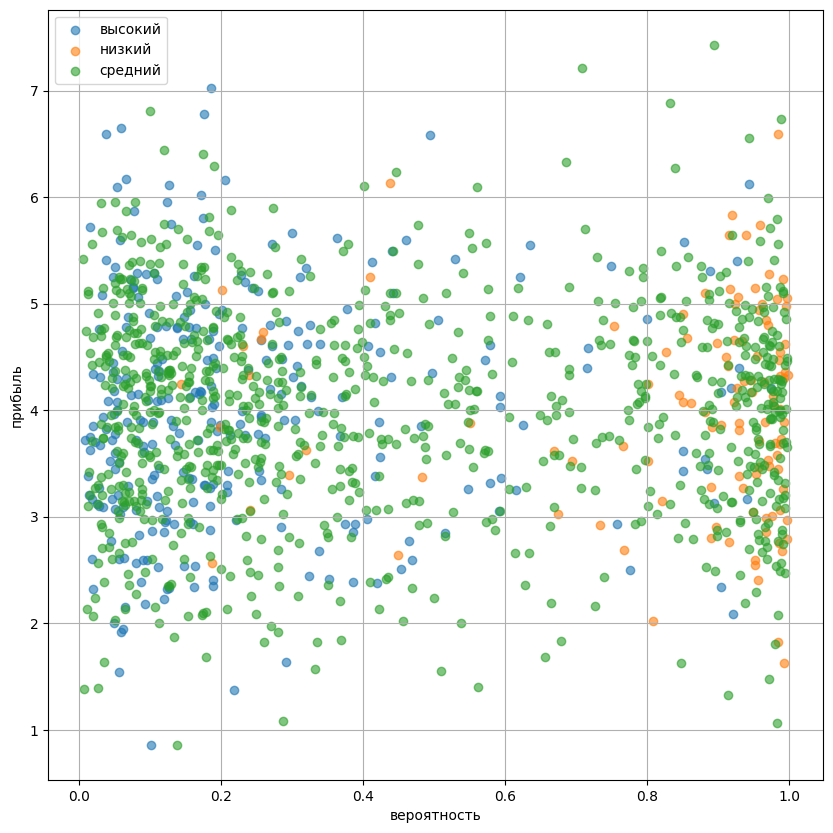

In [145]:
scatter_attr(dataset_market, 'маркет_актив_6_мес_3_кат')

Если средние значения признака распределились вдоль оси 'Вероятность', примерно равномерно, то низкие значения сконцентрировались у значений вероятностей 0.8 - 1.0.

### Критерий сегментирования - маркет_актив_тек_мес

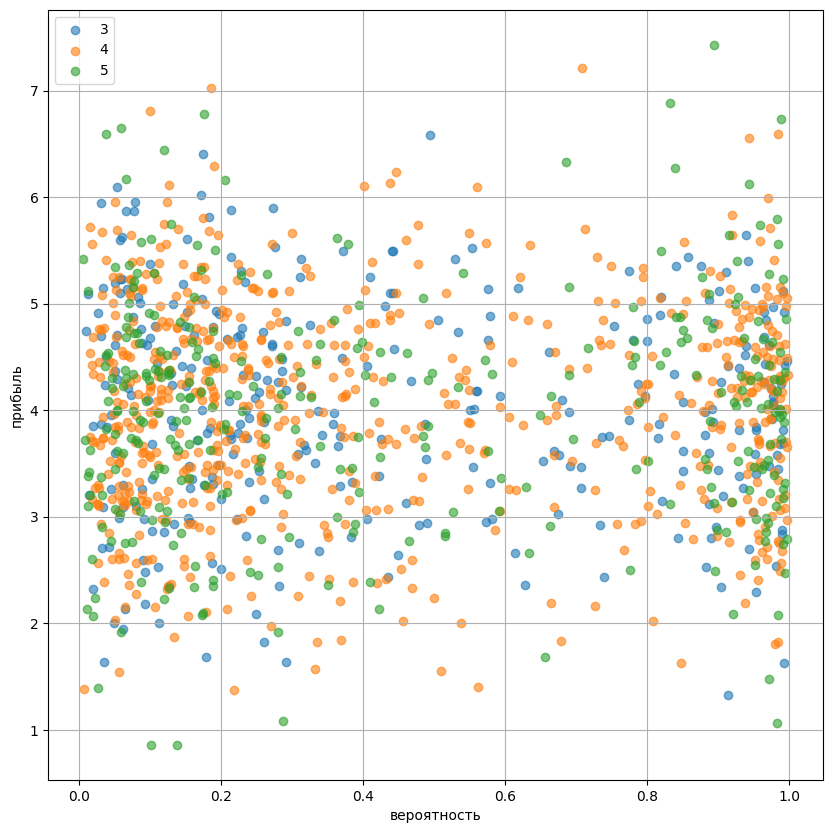

In [146]:
scatter_attr(dataset_market, 'маркет_актив_тек_мес')

Этот признак, так же не включался в тренировочную выборку, как маловлияющий. Очевидно, что по нему сегментировать покупателей невозможно.

### Критерий сегментирования - длительность

In [147]:
порог_1_уровень_длительность = 500
порог_2_уровень_длительность = 700
def level_classifier_duration(value):
    if value < порог_1_уровень_длительность:
        return 'низкая'
    elif value > порог_2_уровень_длительность:
        return 'высокая'
    else:
        return 'средняя'
    
dataset_market['длительность_3_кат'] = dataset_market['длительность'].\
map(level_classifier_duration)

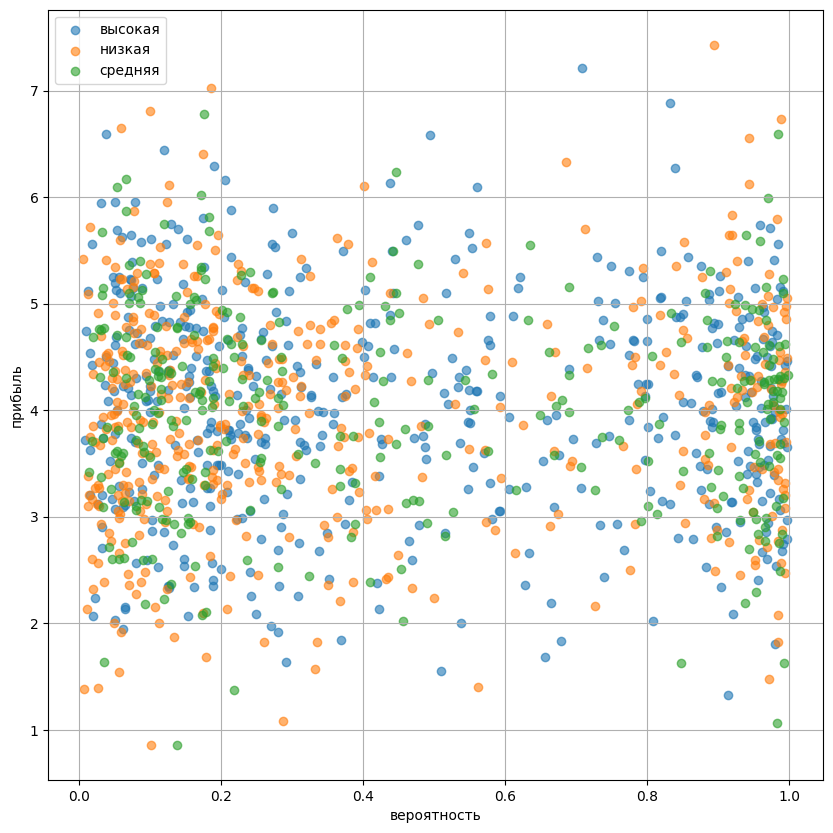

In [148]:
scatter_attr(dataset_market, 'длительность_3_кат')

Тенденции не просматриваются.

### Критерий сегментирования - акционные_покупки

Разделим значения доли акционных покупок по пороговому значению на низкий и высокий уровни.

In [149]:
порог_уровень_акционные_покупки = 0.45
dataset_market['акционные_покупки_уровень'] = dataset_market['акционные_покупки'].\
map(lambda v: 'высокий' if v >= порог_уровень_акционные_покупки else 'низкий')

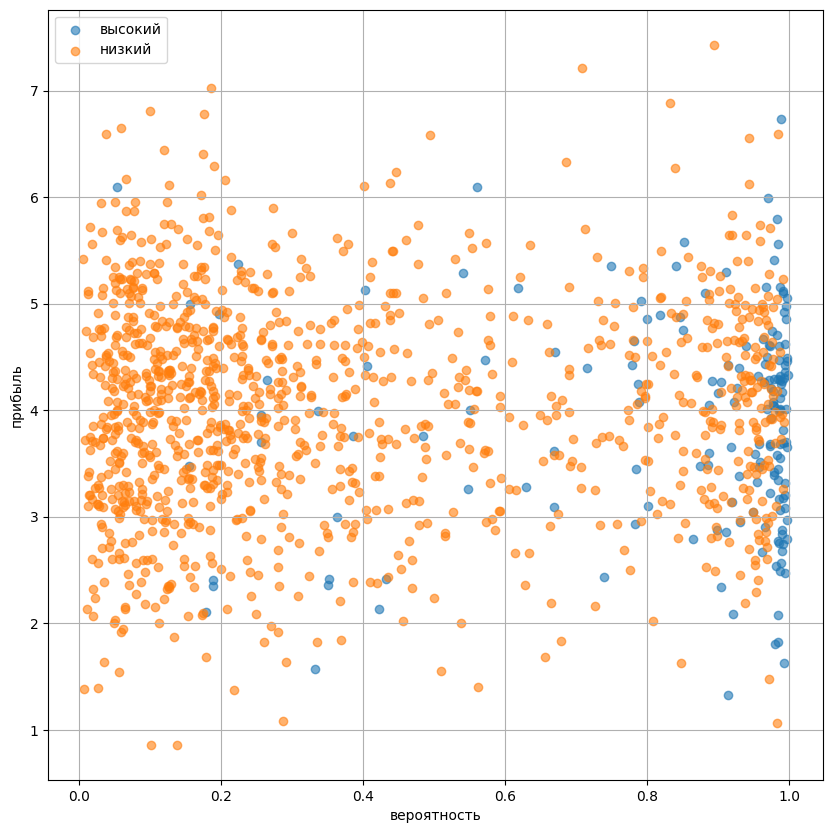

In [150]:
scatter_attr(dataset_market, 'акционные_покупки_уровень')

Отчётливо локализуются в области высоких вероятностей, покупатели с высокой долей в покупках - акционных товаров.

### Критерий сегментирования - популярная_категория

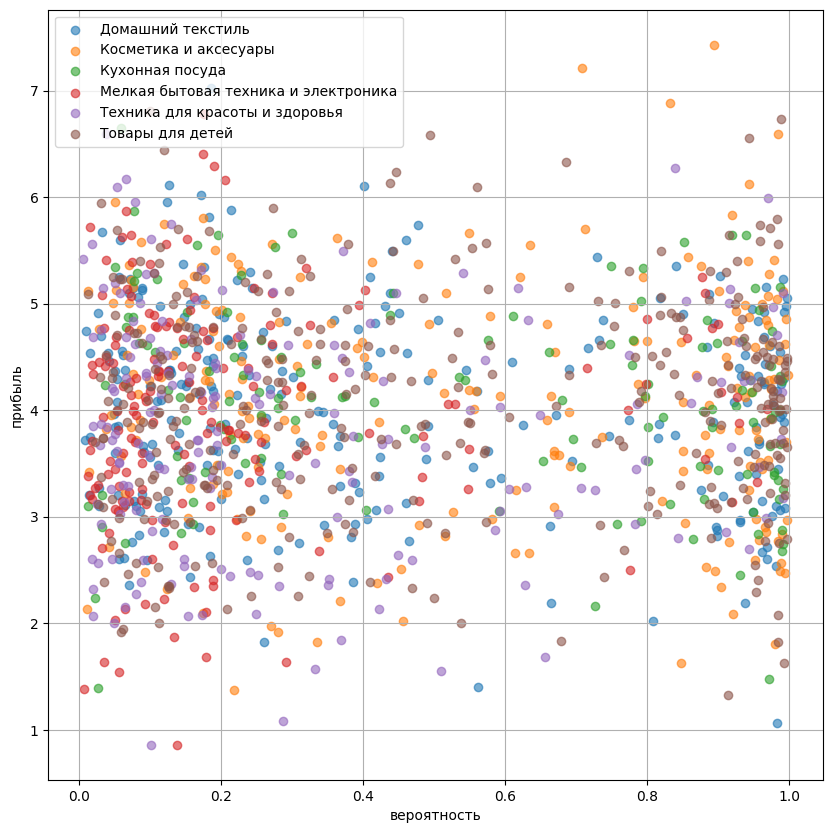

In [151]:
scatter_attr(dataset_market, 'популярная_категория')

В зоне высоких вероятностей, наблюдается низкое количество покупателей с любимой товарной категорией - 'Мелкая бытовая техника и электроника'.

### Критерий сегментирования - средний_просмотр_категорий_за_визит

In [152]:
порог_количество_категорий = 3
dataset_market['средний_просмотр_категорий_за_визит_уровень'] = dataset_market['средний_просмотр_категорий_за_визит'].\
map(lambda v: 'высокий' if v >= порог_количество_категорий else 'низкий')

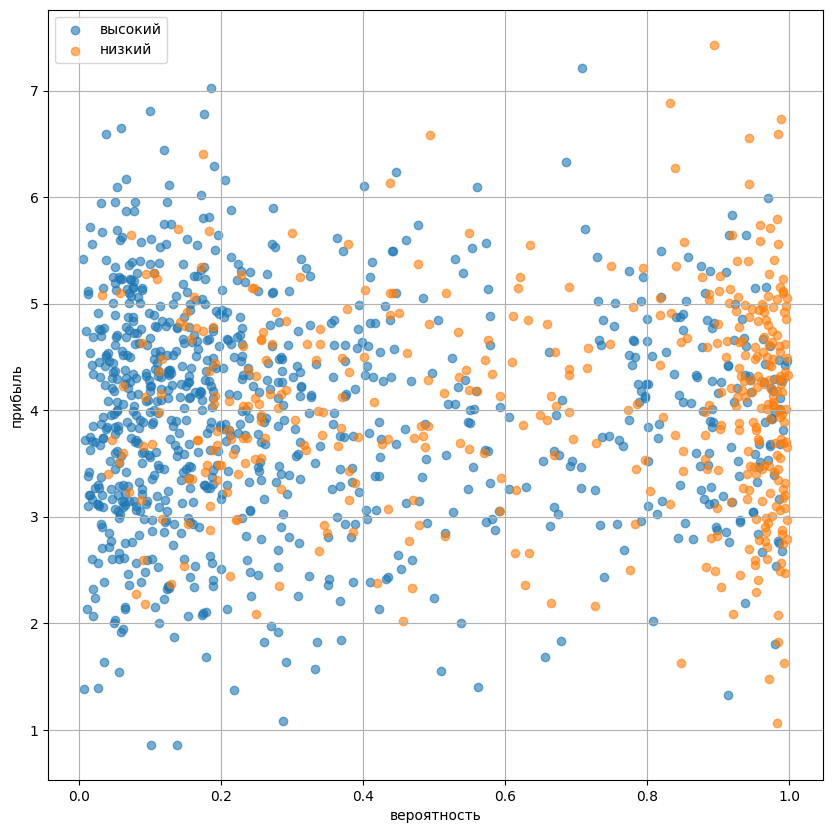

In [153]:
scatter_attr(dataset_market, 'средний_просмотр_категорий_за_визит_уровень')

Покупатели в среднем просматривающие одну или две категорий товаров за визит, явно локализуются в зоне высокой вероятности снижения покупательной активности.

### Критерий сегментирования - неоплаченные_продукты_штук_квартал

In [154]:
порог_1_уровень_неоплаченные_продукты = 6
порог_2_уровень_неоплаченные_продукты = 8
def level_classifier_undayed(value):
    if value < порог_1_уровень_неоплаченные_продукты:
        return 'низкий'
    elif value > порог_2_уровень_неоплаченные_продукты:
        return 'высокий'
    else:
        return 'средний'
    
dataset_market['неоплаченные_продукты_3_кат'] = dataset_market['неоплаченные_продукты_штук_квартал'].\
map(level_classifier_undayed)

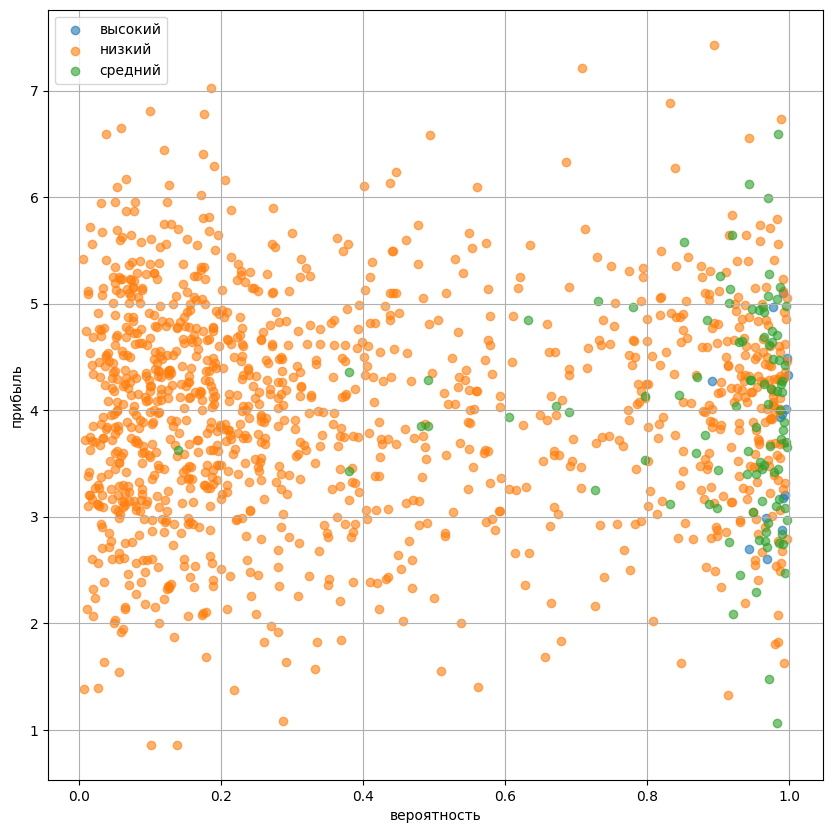

In [155]:
scatter_attr(dataset_market, 'неоплаченные_продукты_3_кат')

Тенденция не ярковыраженная, но присутствует. Пользователи за квартал набравшие от шести до десяти товаров в корзину, практически полностью локализуются в зоне высоких вероятностей. Но пользователи не имеющие в корзине неоплаченных товаров либо набравших не более пяти, распределены вдоль всей оси 'вероятность'.

### Критерий сегментирования - страниц_за_визит

In [156]:
порог_1_уровень_страниц = 6
порог_2_уровень_страниц = 10
def level_classifier_pages(value):
    if value < порог_1_уровень_страниц:
        return 'низкий'
    elif value > порог_2_уровень_страниц:
        return 'высокий'
    else:
        return 'средний'
    
dataset_market['страниц_за_визит_3_кат'] = dataset_market['страниц_за_визит'].\
map(level_classifier_pages)

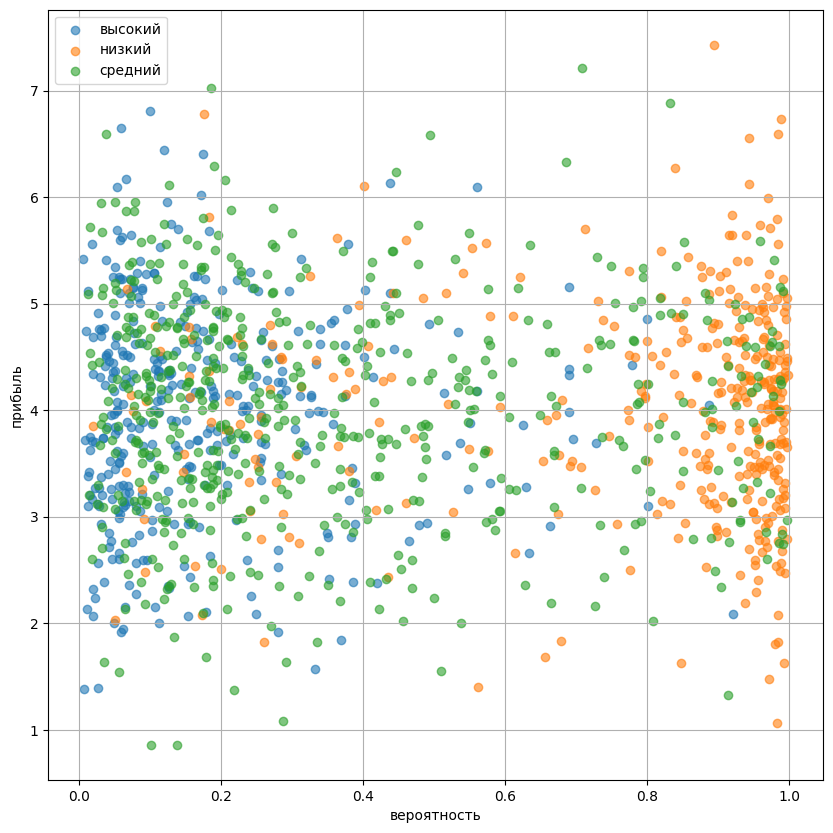

In [157]:
scatter_attr(dataset_market, 'страниц_за_визит_3_кат')

Покупатели с количеством просматриваемых страниц за визит менее шести, преимущественно локализованы в зоне высоких вероятностей.

### Предложения по сокращению снижения покупательской активности

Если отобрать покупателей, с количеством неоплаченых товаров в корзине свыше шести и которые разрешили сообщения от магазина, то получим сегмент покупателей с возможностью прямого влияния.

In [158]:
dataset_target = dataset_market[(dataset_market['разрешить_сообщать'] == 'да') &\
                                (dataset_market['неоплаченные_продукты_штук_квартал'] > 6)]
dataset_target.shape[0]

47

Всего 47 покупателей.

## Вывод

В ходе работы были достигнуты все ранее поставленные цели.

    - Были успешно загружены предоставленные данные. Подобраны корректные разделители значений признаков и дробной части вещественного числа.

    - В ходе предварительной обработки не было выявленно пропусков в данных. Устранены явные и неявные дубликаты в записях данных.

    - В рамках исследовательского анализа, выявлен и устранён аномальный выброс в значениях признака 'выручка'. Установленна ненормальность рапределения всех численных-непрерыных признаков, за исключением признака 'прибыль'. Построены графики распределений значений как категориальных, так и численных дискретных признаков.

    - Все предварительно обработанные данные были последовательно и корректно объеденены в один набор данных.
    
    - В результате проведения корреляционного анализа, выявлена умеренная мультиколлениарность между распределениями значений признаков 'выручка_предыдущий_месяц' и 'выручка_текущий_месяц'. Дополнительно для численных признаков, были расчитаны коэффициенты инфляции дисперсии (VIF). 

    - Была успешно построена и обучена конструкция конвейрного препроцессинга данных. Признаки были разделены на три вида по типу кодирования (ординального или one-hot) или масштабирования (мин/макс или нормализации).
    
    - Была успешно построена и обучена конструкция конвейрного случайного перебора четырёх линейных классификаторов с индивидуальными наборами гиперпараметров. Была произведена оценка качества классификации по двум метрикам (recall и roc_auc) и в итоге выбран лучший классификатор.
    
    - Была показана возможность ручного улучшения классификации и риски связанные с предложенным методом.
    
    - Был произведён анализ влияния значений признаков на классификацию объектов. Выявлены наиболее влиятельные на классификацию объектов признаки, как признаки наблюдения так и признаки прямого воздействия. Определены причинно-следственные связи между характеристиками изменений значений влияющих признаков и соответчтвующие им тенденций классификаций объектов. Построены соответсвующие графики.
    
    - С использованием обнаруженной информации и построенного классификатора, была проведена сегментация объектов по целой гамме признаков. Сегментация позволила выявить группы объектов с явной склонностью к снижению лояльности. Что, в свою очередь, позволило сформировать ряд предложений заказчику, о персонализации взаимодействий с объектами, такими как изменение состава категорий акционных товаров, снижение состава невыкупленных товаров в корзине и пр.